In [1]:
# Packages

import numpy as np
import matplotlib.pyplot as plt
import random

from utils import *
from environment import ButtonsToy
from learner import Learner, bayesian_update, compute_policy, projection
from teacher import BaysesianTeacher, NaiveTeacher, cost

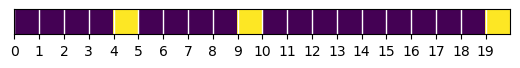

In [9]:
n_buttons = 20
n_music = 3

observation_env = ButtonsToy(n_buttons, n_music)
observation_env.render()

## Learners

In [3]:
types = [0, 1, 2, 3]
traj_size = 150
N = 100
N_envs = 5
dict_learner  = {}
for type in types:
    learner = Learner(type)
    dict_learner[type] = {'actions' : [],
                  'rewards' : []}
    for _ in range(N_envs):
        observation_env = ButtonsToy(n_buttons, n_music)
        for _ in range(N):
            learner.init_env(observation_env)
            actions, rewards = learner.act(traj_size)
            dict_learner[type]['actions'].append(actions)
            dict_learner[type]['rewards'].append(rewards)

/home/chetouani/Documents/STAGE_Clemence/ISIR_internship_ToM/experimental_setup_meta/utils.py:37: RuntimeWarning: divide by zero encountered in log2
  tab = proba_dist * np.log2(proba_dist)
/home/chetouani/Documents/STAGE_Clemence/ISIR_internship_ToM/experimental_setup_meta/utils.py:37: RuntimeWarning: invalid value encountered in multiply
  tab = proba_dist * np.log2(proba_dist)


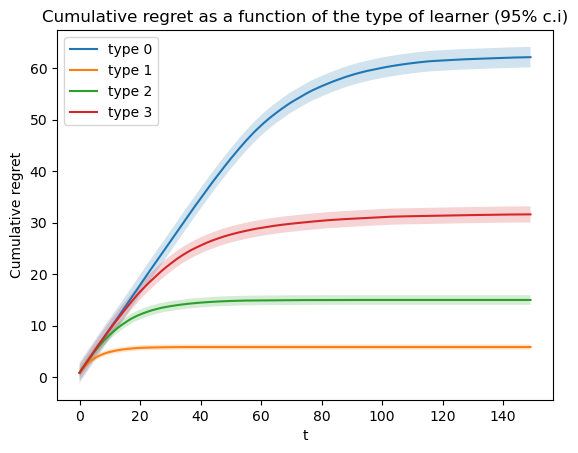

In [4]:
for ii,type in enumerate(types):
    all_rewards = np.array(dict_learner[type]['rewards'])
    all_cum_regrets = np.cumsum(np.ones_like(all_rewards) - all_rewards, axis=1)
    mean, std = np.mean(all_cum_regrets, axis=0), np.std(all_cum_regrets)

    plt.plot(mean, label=f'type {type}')
    plt.fill_between(np.arange(traj_size), mean + 1.96 * std / np.sqrt(N * N_envs), mean - 1.96 * std / np.sqrt(N * N_envs), alpha=0.2)
    plt.ylabel('Cumulative regret')
    plt.xlabel('t')
    plt.title('Cumulative regret as a function of the type of learner (95% c.i)')
    plt.legend()

## Bayesian based ToM teacher

Observation environment


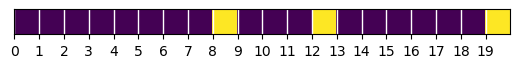

Demonstration environment


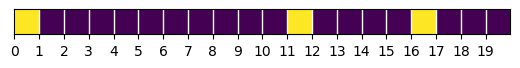

In [10]:
observation_env = ButtonsToy(n_buttons, n_music)
print('Observation environment')
observation_env.render()
plt.show()

demonstration_env = ButtonsToy(n_buttons, n_music)
print('Demonstration environment')
demonstration_env.render()
plt.show()

num_types = 4
teacher = BaysesianTeacher(env=observation_env, num_types=num_types)
learner = Learner(type=3)
learner.init_env(observation_env)

### Predict learner type (Maximum A Posteriori)

In [6]:
N = 200
N_envs = 10
num_obs = 100

dict = {}

for type in range(num_types):
    dict[type] = []
    for _ in range(N_envs):
        # Init envs
        observation_env = ButtonsToy(n_buttons, n_music)
        demonstration_env = ButtonsToy(n_buttons, n_music)
        for _ in range(N):
            # Init teacher
            teacher = BaysesianTeacher(env=observation_env,
                                    num_types=num_types)
            # Init learner
            learner = Learner(type)
            learner.init_env(observation_env)

            accuracies = []
            for _ in range(num_obs):
                accuracies.append(type == teacher.predict_learner_type())
                traj = learner.act()
                teacher.observe(traj)
            dict[type].append(accuracies)

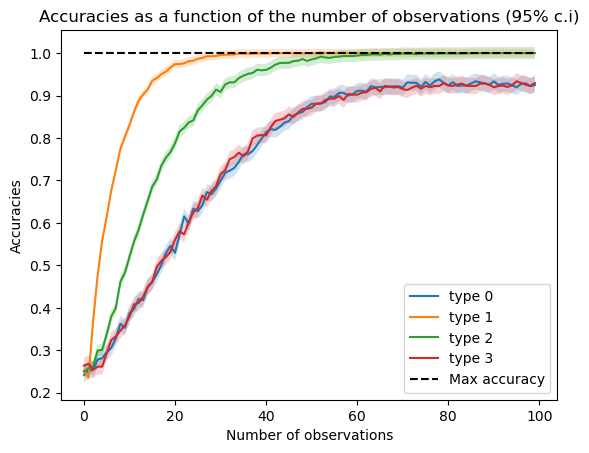

In [7]:
for type in range(num_types):
    accuracies = np.array(dict[type])
    mean, std = np.mean(accuracies, axis=0), np.std(accuracies)

    plt.plot(mean, label=f'type {type}')
    plt.fill_between(np.arange(num_obs), mean + 1.96 * std / np.sqrt(N * N_envs), mean - 1.96 * std / np.sqrt(N * N_envs), alpha=0.2)
    plt.ylabel('Accuracies')
    plt.xlabel('Number of observations')
    plt.title('Accuracies as a function of the number of observations (95% c.i)')
plt.plot(np.arange(num_obs), [1] * num_obs, c='k', label="Max accuracy", ls='--')
plt.legend();

In [8]:
## Failure mode studies

N = 100
N_envs = 1
num_obs = 300

LOG = True

dict = {}

for type in range(num_types):
    dict[type] = {}
    dict[type]['accuracies'] = []
    dict[type]['beliefs'] = []
    for _ in range(N_envs):
        # Init envs
        observation_env = ButtonsToy(n_buttons, n_music)
        demonstration_env = ButtonsToy(n_buttons, n_music)
        for _ in range(N):
            # Init teacher
            teacher = BaysesianTeacher(env=observation_env,
                                    num_types=num_types)
            # Init learner
            learner = Learner(type)
            learner.init_env(observation_env)

            accuracies = []
            all_beliefs = []
            tag_traj = []
            for _ in range(num_obs):
                all_beliefs.append(teacher.beliefs.copy())
                accuracies.append(type == teacher.predict_learner_type())
                traj = learner.act()
                teacher.observe(traj)
                tag_traj.append(traj)

            # If prediction failure after 300 observations
            if LOG and type != teacher.predict_learner_type():
                # print LOG
                print(f'LOG FAILURE : type {type} beliefs {teacher.beliefs} trajectory {tag_traj}')

            dict[type]['beliefs'].append(all_beliefs)
            dict[type]['accuracies'].append(accuracies)

LOG FAILURE : type 0 beliefs [0.49798818 0.00201182 0.00201182 0.49798818] trajectory [([1], [0.0]), ([8], [0.0]), ([3], [0.0]), ([16], [0.0]), ([18], [0.0]), ([11], [0.0]), ([9], [0.0]), ([16], [0.0]), ([16], [0.0]), ([2], [0.0]), ([11], [0.0]), ([2], [0.0]), ([1], [0.0]), ([16], [0.0]), ([10], [0.0]), ([8], [0.0]), ([5], [0.0]), ([10], [0.0]), ([0], [1.0]), ([19], [0.0]), ([11], [0.0]), ([5], [0.0]), ([18], [0.0]), ([14], [0.0]), ([19], [0.0]), ([19], [0.0]), ([13], [0.0]), ([8], [0.0]), ([17], [0.0]), ([17], [0.0]), ([18], [0.0]), ([9], [0.0]), ([14], [0.0]), ([5], [0.0]), ([9], [0.0]), ([15], [0.0]), ([15], [0.0]), ([2], [0.0]), ([3], [0.0]), ([18], [0.0]), ([10], [0.0]), ([5], [0.0]), ([13], [0.0]), ([15], [0.0]), ([12], [0.0]), ([7], [0.0]), ([13], [0.0]), ([19], [0.0]), ([13], [0.0]), ([10], [0.0]), ([11], [0.0]), ([4], [1.0]), ([1], [0.0]), ([7], [0.0]), ([3], [0.0]), ([2], [0.0]), ([12], [0.0]), ([5], [0.0]), ([10], [0.0]), ([19], [0.0]), ([8], [0.0]), ([2], [0.0]), ([10], [0.

### Demonstrate

Observation environment


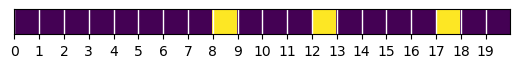

Demonstration environment


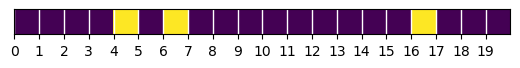

In [11]:
observation_env = ButtonsToy(n_buttons, n_music)
print('Observation environment')
observation_env.render()
plt.show()

demonstration_env = ButtonsToy(n_buttons, n_music)
print('Demonstration environment')
demonstration_env.render()
plt.show()

num_types = 4
num_demo_types = 4
teacher = BaysesianTeacher(env=observation_env, num_types=num_types)
learner = Learner(type=2)
learner.init_env(observation_env)

In [47]:
# Global evaluation parameters
#DICT = {}
DICT = load_data('/home/chetouani/Documents/STAGE_Clemence/ISIR_internship_ToM/experimental_setup_meta/outputs/bayesian_ToM/teacher_eval.json')
LOADED = True

N = 100
N_envs = 3
num_obs = 50

n_eval = 20

#### Experiments and display

In [13]:
def evaluate(method: str, alpha: float) -> None:
    if method not in DICT.keys():
        DICT[method] = {}
    DICT[method][alpha] = {}
    for type in range(num_types):
        DICT[method][alpha][type] = {}
        DICT[method][alpha][type]['rewards'] = []
        DICT[method][alpha][type]['demo'] = []
        DICT[method][alpha][type]['uncertainty'] = []
        DICT[method][alpha][type]['teacher_regret'] = []
        for _ in range(N_envs):
            # Init envs
            observation_env = ButtonsToy(n_buttons, n_music)
            demonstration_env = ButtonsToy(n_buttons, n_music)
            for _ in range(N):
                cum_rewards = []
                all_demo = []
                uncertainties = []
                teacher_regret = []
                for n in range(num_obs):
                    # Init teacher
                    if method == 'MAP' or method == 'Bayesian':
                        teacher = BaysesianTeacher(env=observation_env,
                                                    num_types=num_types)
                    elif method == 'Uniform' or method == 'No_utility':
                        teacher = NaiveTeacher(env=observation_env,
                                                    num_types=num_types)
                    # Init learner
                    learner = Learner(type)
                    learner.init_env(observation_env)
                    if method == 'MAP' or method == 'Bayesian':
                        # Observe the learner
                        traj = learner.act(size=n)
                        teacher.observe(traj)
                        # Teacher uncertainty
                        uncertainties.append(Shannon_entropy(teacher.beliefs))
                    # Chose demonstration
                    teacher.init_env(demonstration_env)
                    demo = teacher.demonstrate(method=method, alpha=alpha)
                    # Teacher regret on its demonstration choice
                    teacher_regret.append(cost(demo, alpha=alpha) - cost(teacher.demonstrations[type], alpha=alpha))
                    # Show the demonstration
                    learner.init_env(demonstration_env)
                    learner.observe(demo)
                    # Evaluate hwo helpful has been the demonstration
                    _, rewards = learner.act(size=n_eval)
                    # Append
                    cum_rewards.append(np.sum(rewards))
                    all_demo.append(len(demo[0]))
                DICT[method][alpha][type]['rewards'].append(cum_rewards)
                DICT[method][alpha][type]['demo'].append(all_demo)
                DICT[method][alpha][type]['uncertainty'].append(uncertainties)
                DICT[method][alpha][type]['teacher_regret'].append(teacher_regret)

In [70]:
def display_evaluation(method: str, alpha: float, save: bool=True) -> None:
    demo_colors = ['m', 'red', 'orange', 'pink']

    if LOADED:
        alpha = str(alpha)

    fig0 = plt.figure(figsize=(15,5))
    # Mean over the type of learner of the total reward on trajectory of size 20  (after seen the demo chosen by the teacher)
    all_evals = np.array([DICT[method][alpha][str(type)]['rewards'] if LOADED else DICT[method][alpha][type]['rewards'] for type in range(num_types)]).mean(axis=0)
    mean = np.mean(all_evals, axis=0)
    std = np.std(all_evals)

    plt.plot(mean, label=f'Mean over all the types', color='saddlebrown')
    plt.ylim(0, 21)
    plt.fill_between(np.arange(num_obs), mean + 1.96 * std / np.sqrt(N * N_envs), mean - 1.96 * std/np.sqrt(N * N_envs), alpha=0.2, color='saddlebrown')
    plt.plot(np.arange(num_obs), [20] * num_obs, c='k', label="Max", ls='--')
    plt.title(fr' Demonstration chosen by $\mathbf{{{method}}}$ teacher ' + f'\n cost parameter alpha={alpha}')

    plt.xlabel('Number of observations')
    plt.ylabel('Learner reward')
    plt.legend()

    fig1 = plt.figure(figsize=(15,5))
    # Learner total reward on trajectory of size 20 (after seen the demo chosen by the teacher for each type of learner)
    fig1.add_subplot(1,2,1)
    for type in range(num_types):
        if LOADED:
            type = str(type)
        all_evals = np.array(DICT[method][alpha][type]['rewards'])
        mean = np.mean(all_evals, axis=0)
        std = np.std(all_evals)

        plt.plot(mean, label=f'type = {type}')
        plt.ylim(0, 21)
        plt.fill_between(np.arange(num_obs), mean + 1.96 * std / np.sqrt(N * N_envs), mean - 1.96 * std / np.sqrt(N * N_envs), alpha=0.2)
    plt.plot(np.arange(num_obs), [20] * num_obs, c='k', label="Max", ls='--')
    plt.title(fr' Demonstration chosen by $\mathbf{{{method}}}$ teacher ' + f'\n cost parameter alpha={alpha}')

    plt.xlabel('Number of observations')
    plt.ylabel('Learner reward')
    plt.legend()

    # Teacher uncertainty
    if method == 'MAP' or method == 'Bayesian':
        fig1.add_subplot(1,2,2)
        for type in range(num_types):
            if LOADED:
                type = str(type)
            all_evals = np.array(DICT[method][alpha][type]['uncertainty'])
            mean = np.mean(all_evals, axis=0)
            std = np.std(all_evals)

            plt.plot(mean, label=f'type = {type}')
            plt.ylim(- 0.5 , Shannon_entropy(np.ones(num_types) / num_types) + 0.5)
            plt.fill_between(np.arange(num_obs), mean + 1.96 * std / np.sqrt(N * N_envs), mean - 1.96 * std/np.sqrt(N * N_envs), alpha=0.2)
        plt.plot(np.arange(num_obs), [0] * num_obs, c='k', label="Min", ls='--')
        plt.title(fr'$\mathbf{{{method}}}$ teacher')

        plt.xlabel('Number of observations')
        plt.ylabel('Teacher uncertainty (Shannon entropy)')
        plt.legend()

    # Repartition btw type of demonstrations shown
    fig2, axes = plt.subplots(1, 4, figsize=(25,5))
    for type in range(num_types):
        ax = axes[type]
        if LOADED:
            type = str(type)
        for demo_type in range(num_demo_types):
            demo_rep = np.array(DICT[method][alpha][type]['demo'])
            if demo_type == 0:
                prop_demo = np.array(demo_rep == n_buttons)
            else:
                prop_demo = np.array(demo_rep == demo_type)
            mean = np.mean(prop_demo, axis=0)
            std = np.std(prop_demo)

            ax.plot(mean, label=f'demo type = {demo_type}', color=demo_colors[demo_type])
            ax.fill_between(np.arange(num_obs), mean + 1.96 * std / np.sqrt(N + N_envs), mean - 1.96 * std/np.sqrt(N + N_envs), alpha=0.2, color=demo_colors[demo_type])
        ax.plot(np.arange(num_obs), [1] * num_obs, c='k', label="Max", ls='--')

        ax.set_title(f'% of each demo type for learner of $\mathbf{{type}}$ ' + fr'$\mathbf{{{type}}}$' +  f'\n {method} teacher, cost parameter alpha={alpha}')
        ax.set_xlabel('Number of observations')
        ax.set_ylabel('Proportion')
        ax.legend()

    # Teacher regret on the cost of the demonstration he showed
    fig3, axes = plt.subplots(1, 4, figsize=(25,5))
    for type in range(num_types):
        ax = axes[type]
        if LOADED:
            type = str(type)
        all_regrets = np.array(DICT[method][alpha][type]['teacher_regret'])
        mean = np.mean(all_regrets, axis=0)
        std = np.std(all_regrets)

        ax.plot(mean, label=f'type = {type}', color='c')
        ax.fill_between(np.arange(num_obs), mean + 1.96 * std / np.sqrt(N * N_envs), mean - 1.96 * std/np.sqrt(N * N_envs), alpha=0.2, color='c')
        ax.set_ylim( - (float(alpha) * (n_buttons - 1) + 0.02), float(alpha) * (n_buttons - 1) + 0.02)
        ax.plot(np.arange(num_obs), [0] * num_obs, c='k', ls='--')

        ax.set_title(f'Teacher regret for learner of $\mathbf{{type}}$ ' + fr'$\mathbf{{{type}}}$' +  f'\n {method} teacher, cost parameter alpha={alpha}')
        ax.set_xlabel('Number of observations')
        ax.set_ylabel('Regret')
        ax.legend()

    # Super figure
    figs = [fig0, fig1, fig2, fig3]
    saving_names = ['mean', 'per_type', 'chosen_demo', 'teacher_regret']
    if save:
        for ii, fig in enumerate(figs):
            fig.savefig(f'/home/chetouani/Documents/STAGE_Clemence/ISIR_internship_ToM/experimental_setup_meta/figures/bayesian_ToM/{method}/eval_{saving_names[ii]}_{method}_{alpha}.png')

#### MAP teacher

In [15]:
method = 'MAP'
alpha_values = [0.01, 0.02]

for alpha in alpha_values:
    evaluate(method, alpha)

/home/chetouani/Documents/STAGE_Clemence/ISIR_internship_ToM/experimental_setup_meta/learner.py:31: RuntimeWarning: invalid value encountered in divide
  updated_beliefs[a, :] /= updated_beliefs[a, :].sum()


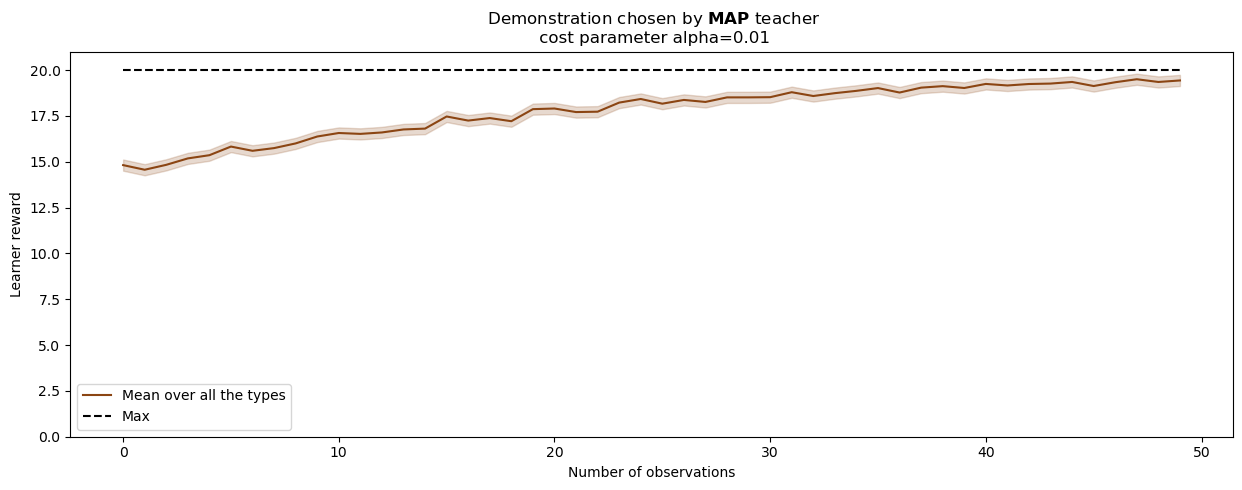

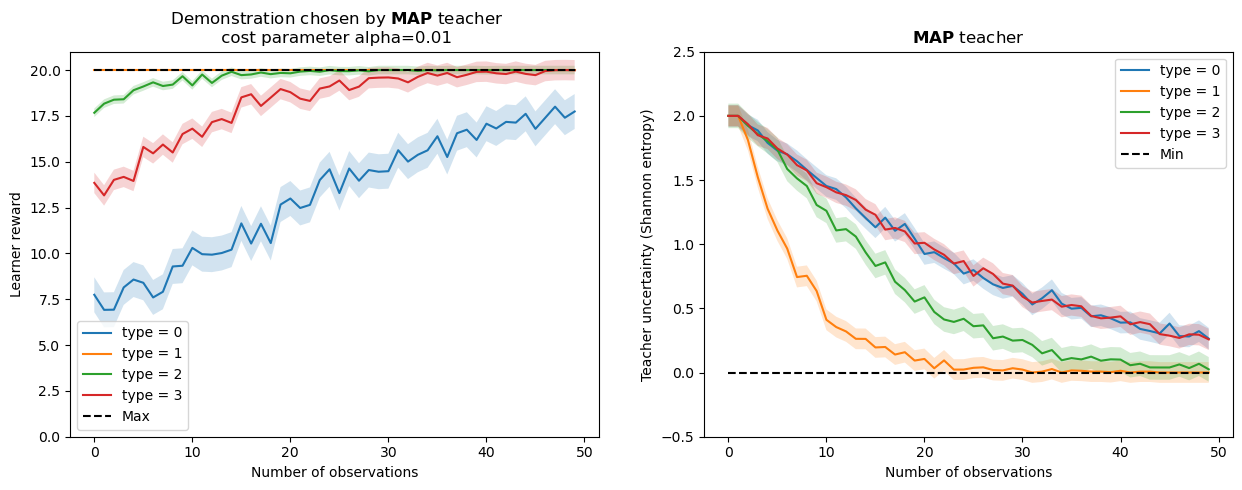

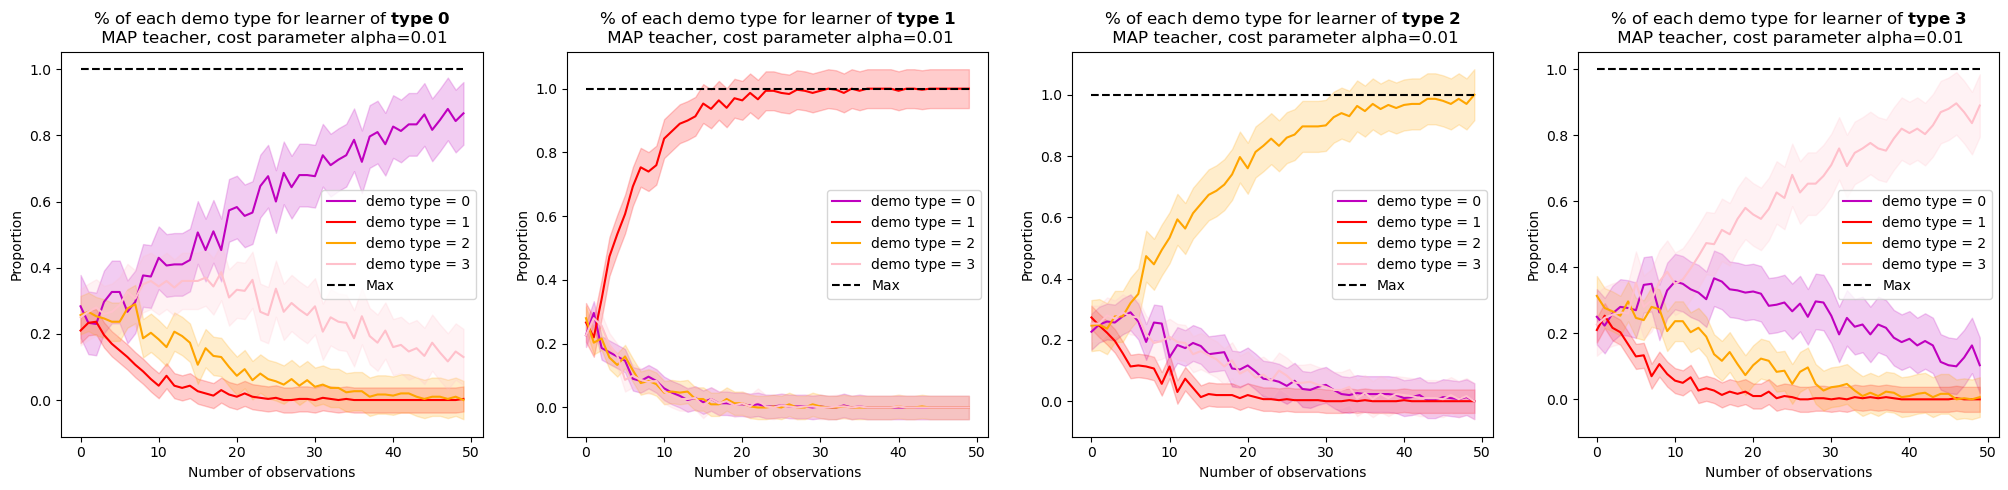

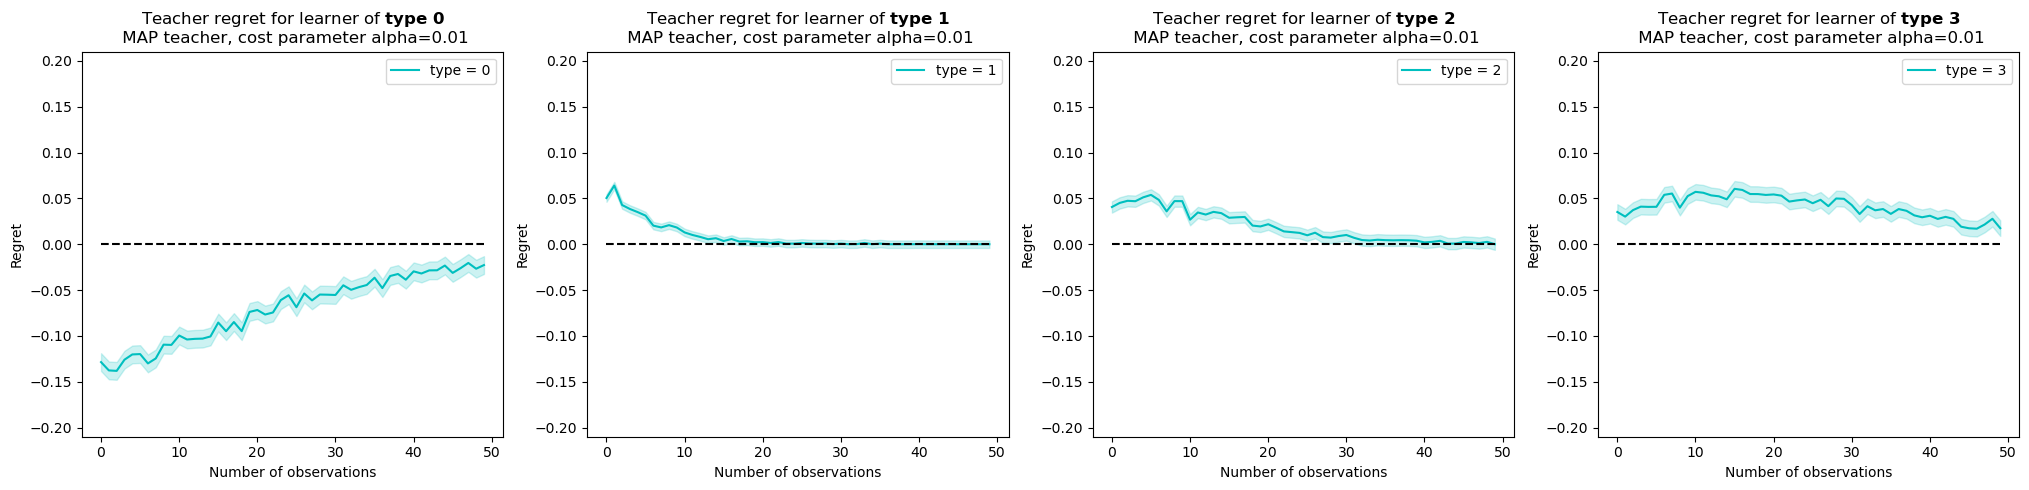

In [72]:
method, alpha = 'MAP', alpha_values[0]
display_evaluation(method, alpha)

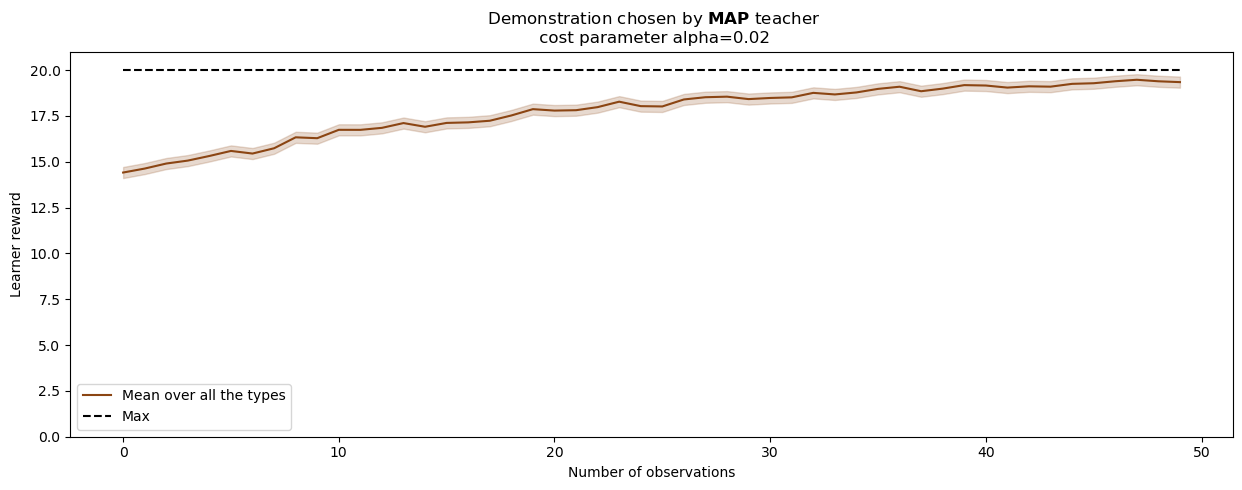

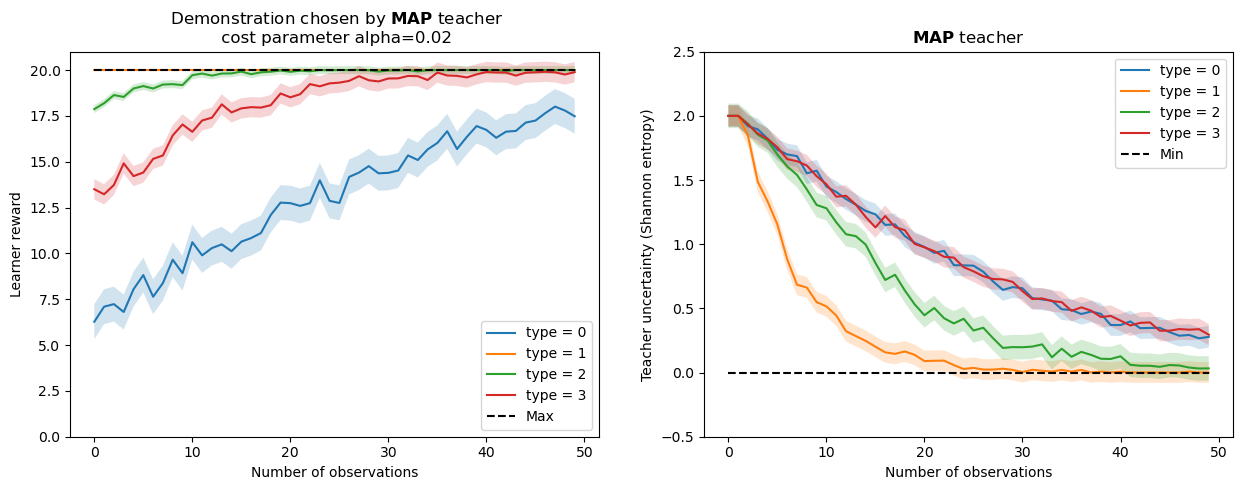

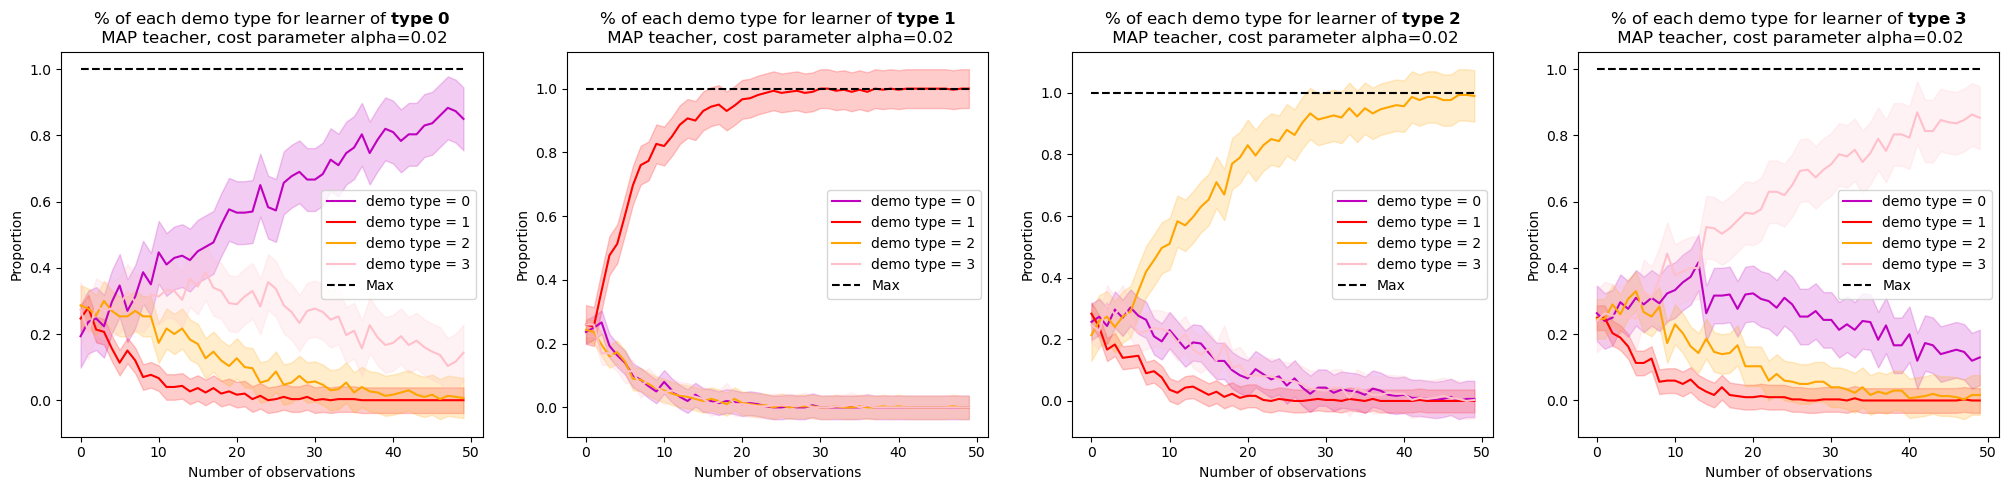

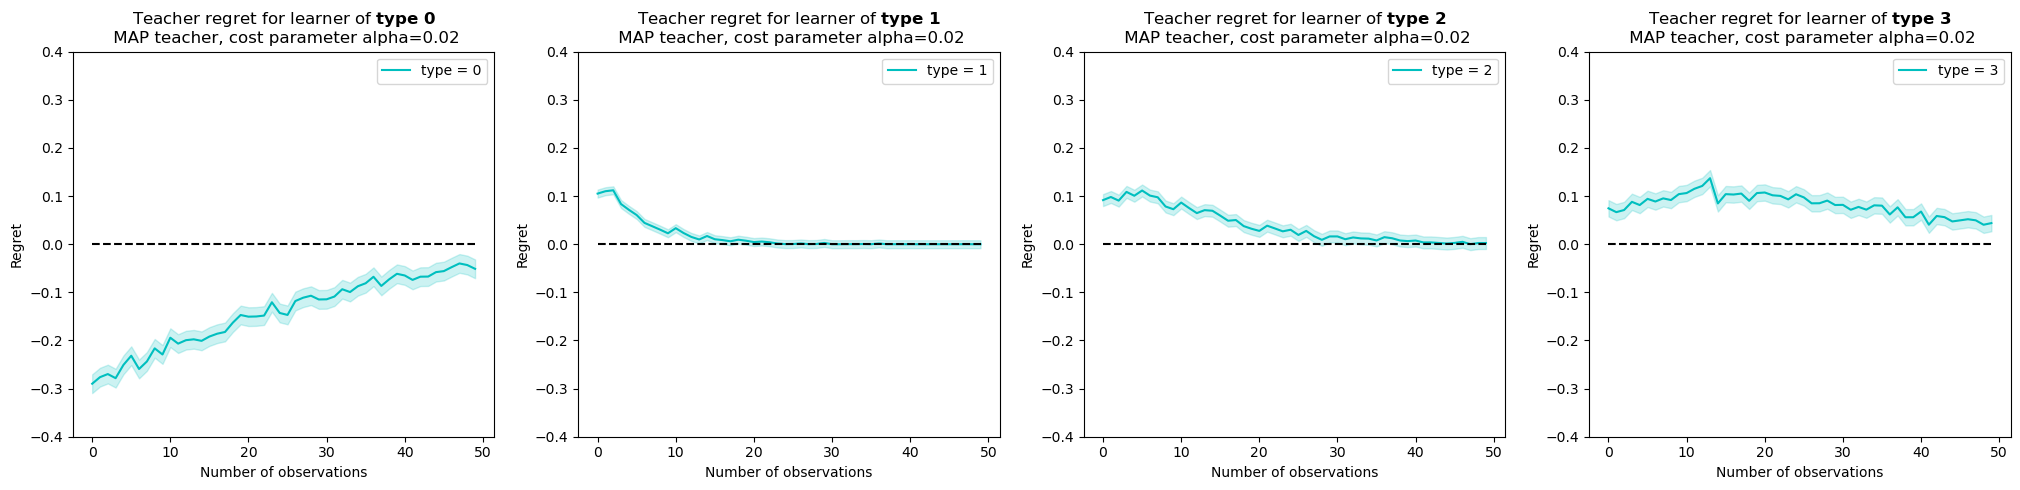

In [73]:
method, alpha = 'MAP', alpha_values[1]
display_evaluation(method, alpha)

#### Bayesian teacher

In [18]:
method = 'Bayesian'
alpha_values = [0.01, 0.02]

for alpha in alpha_values:
    evaluate(method, alpha)

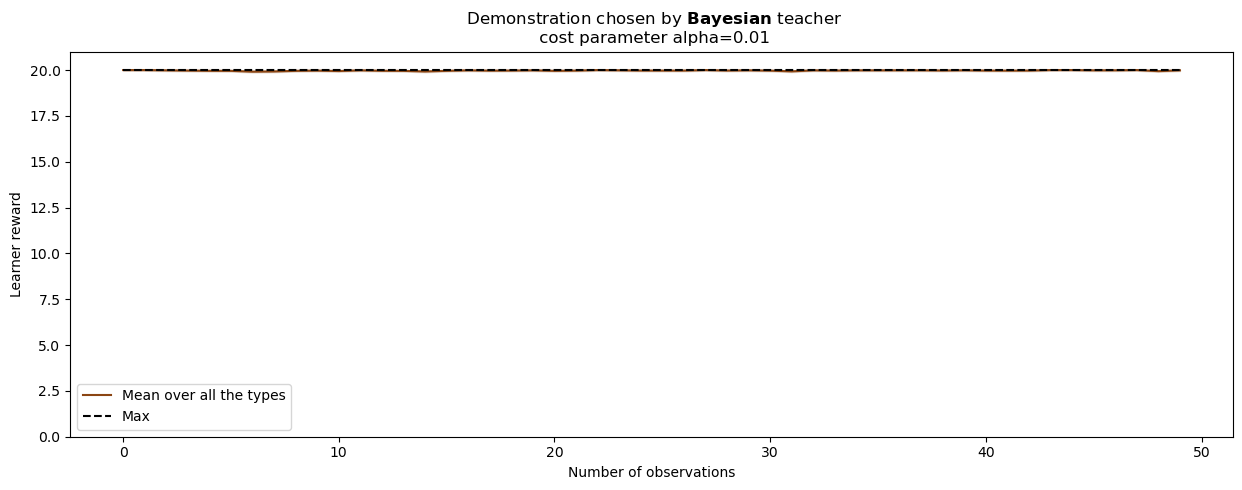

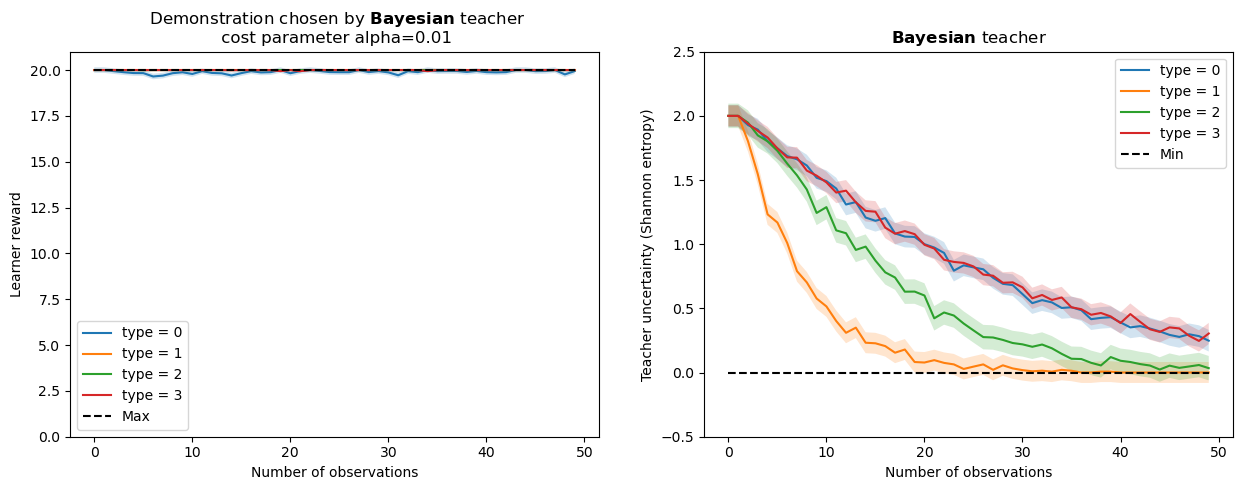

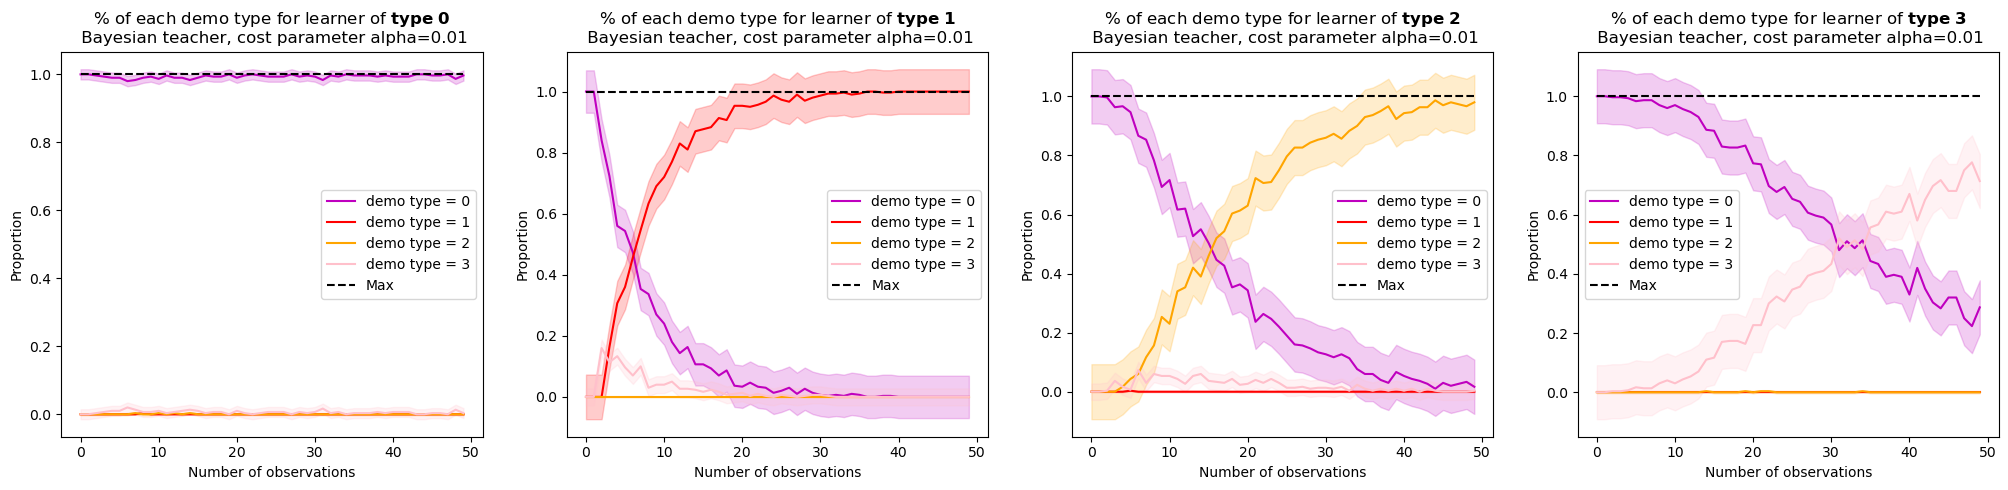

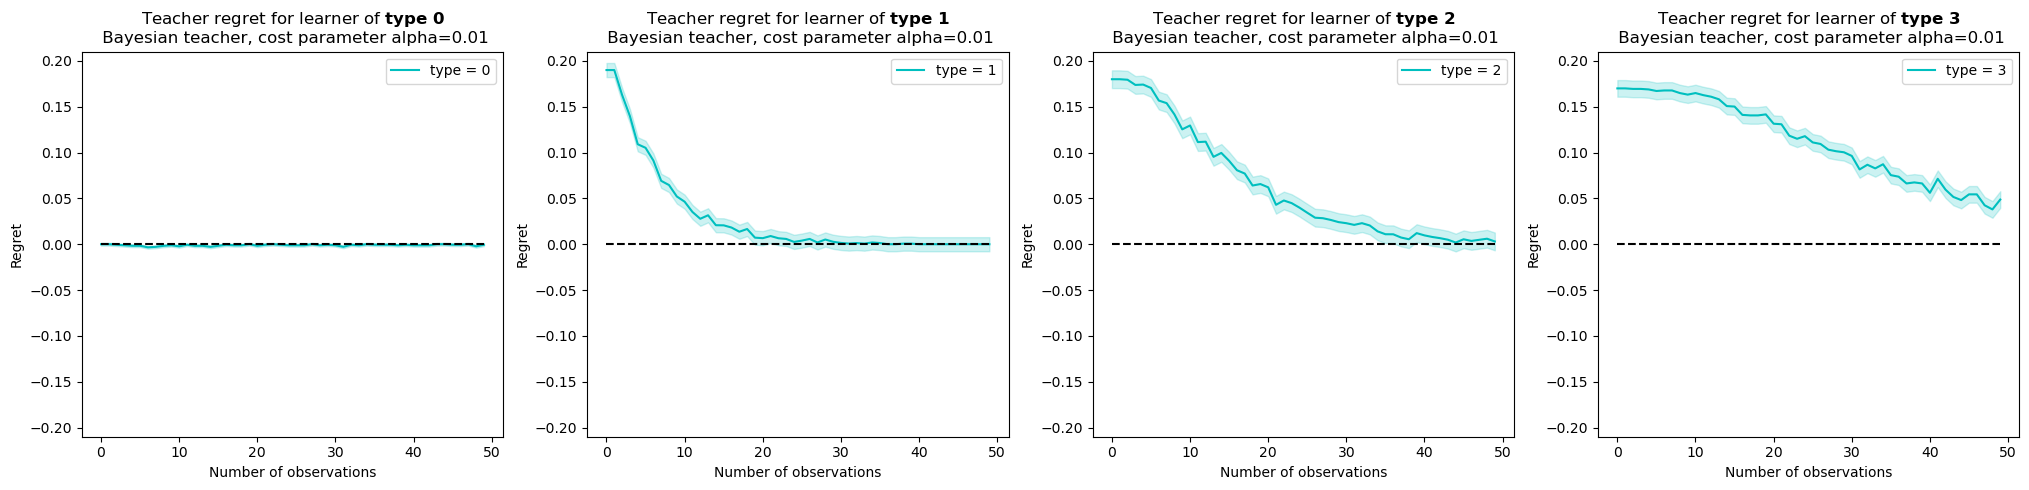

In [75]:
method, alpha = 'Bayesian', alpha_values[0]
display_evaluation(method, alpha)

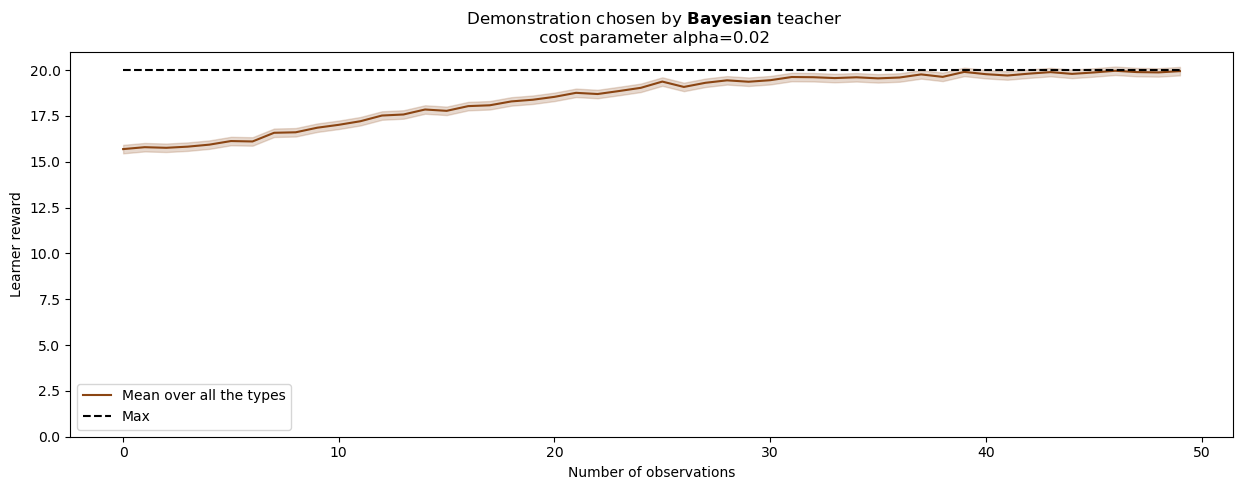

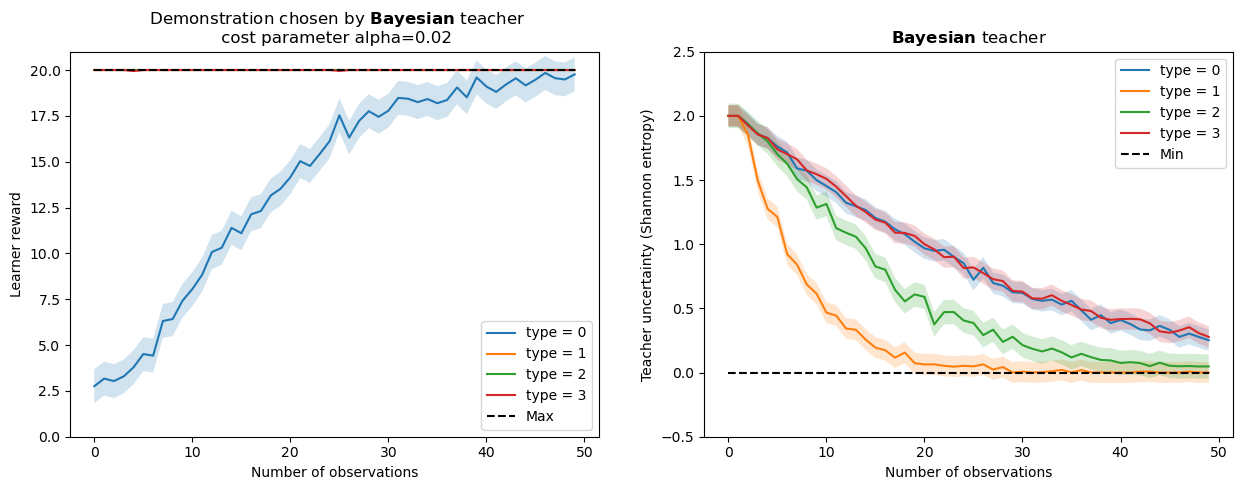

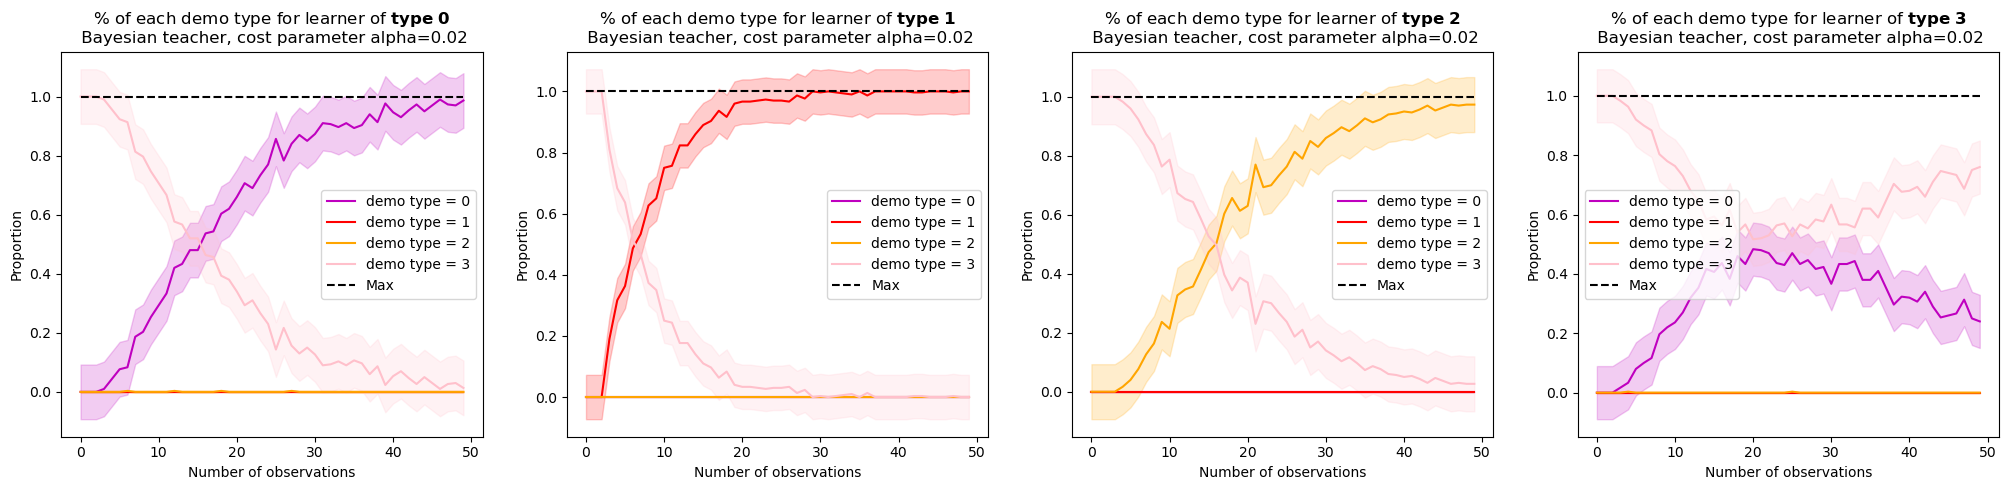

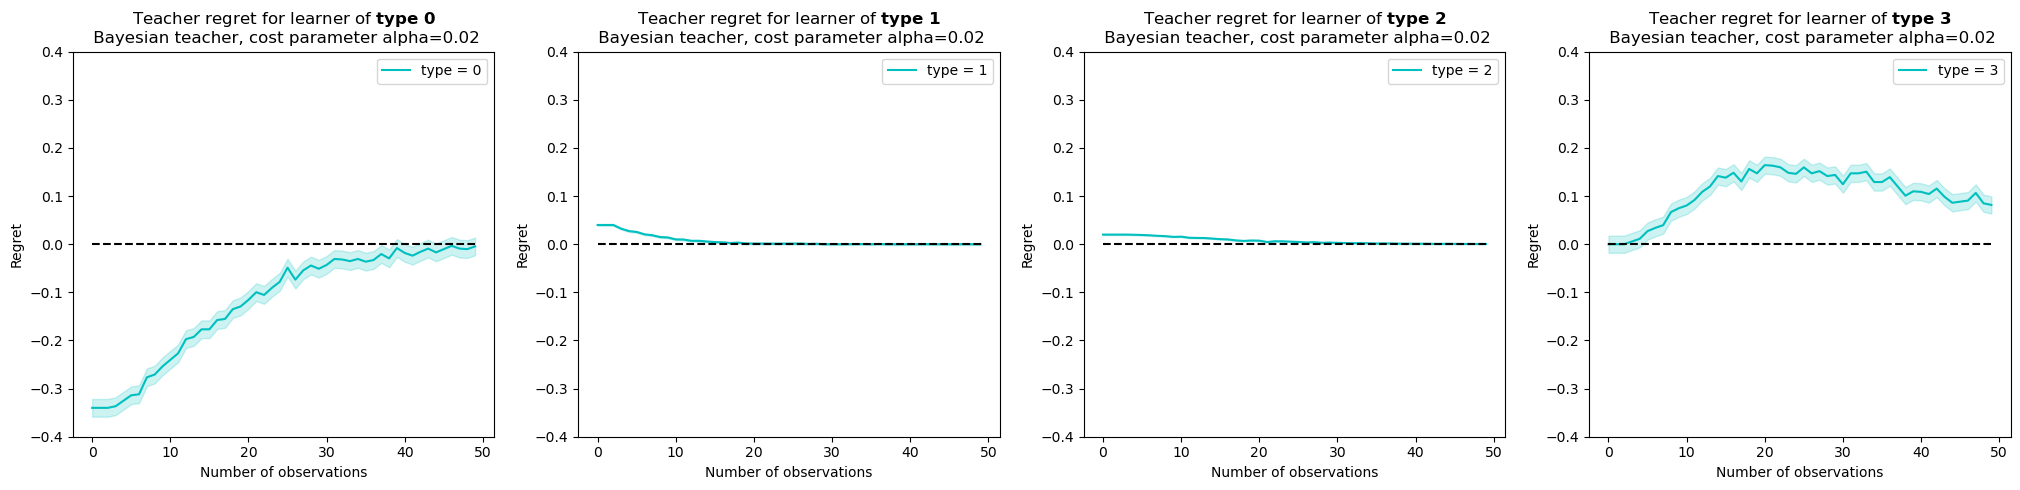

In [76]:
method, alpha = 'Bayesian', alpha_values[1]
display_evaluation(method, alpha)

#### Uniform teacher

In [21]:
method = 'Uniform'
alpha = 0.01 # Only to compute teacher regret

evaluate(method, alpha)

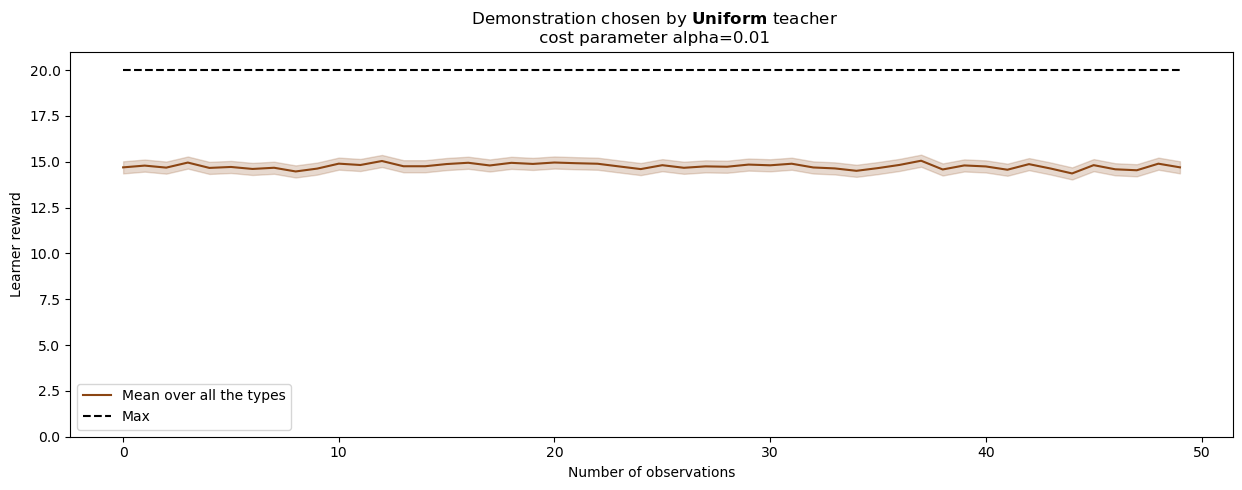

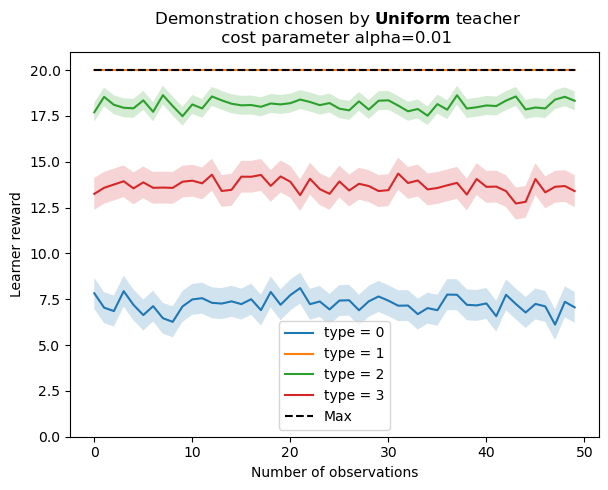

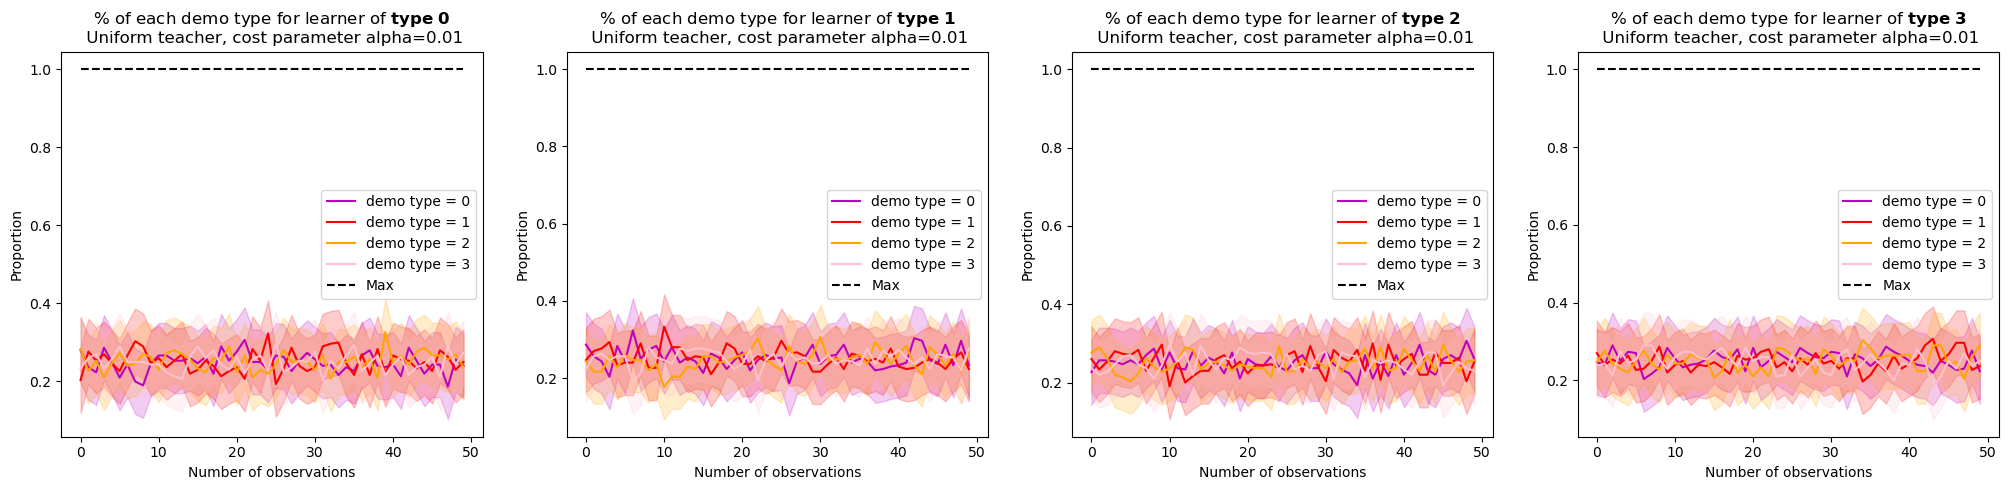

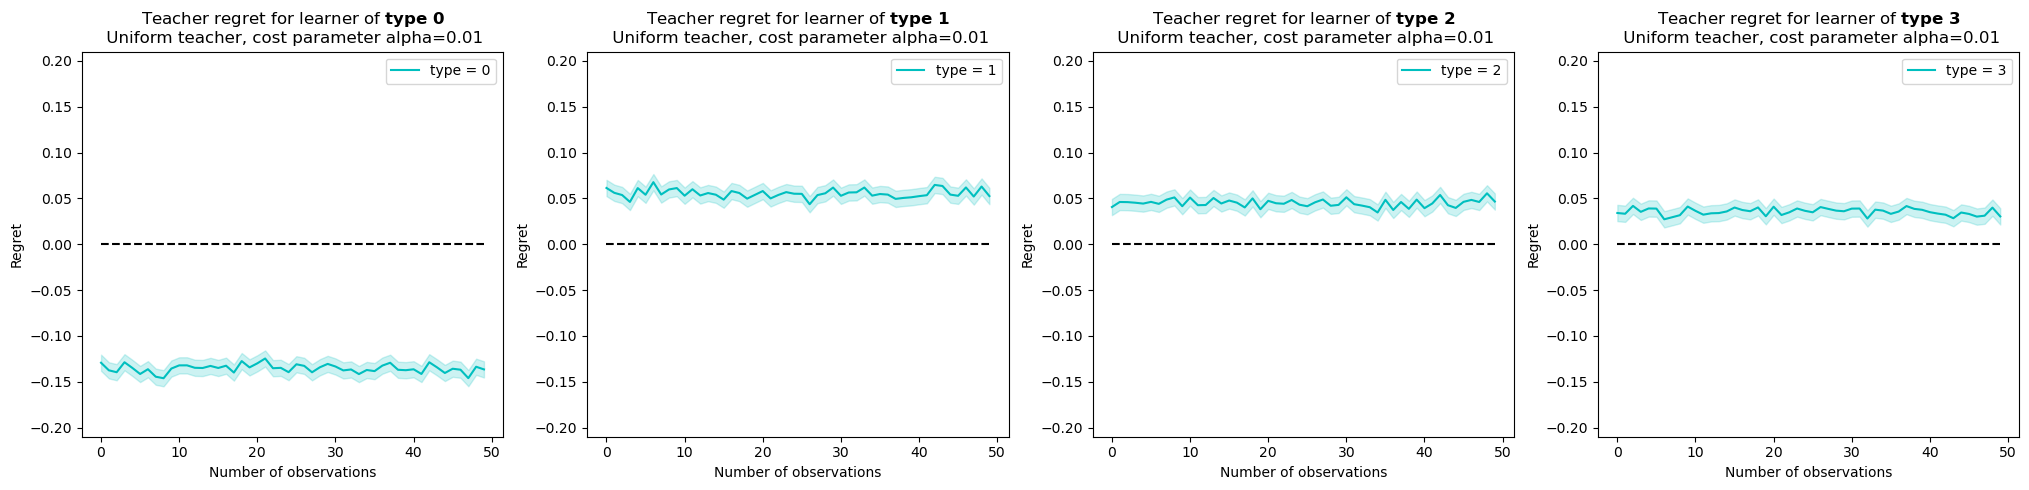

In [77]:
method, alpha = 'Uniform', 0.01
display_evaluation(method, alpha)

#### No_utility teacher

In [23]:
method = 'No_utility'
alpha = 0.01 # Only to compute teacher regret

evaluate(method, alpha)

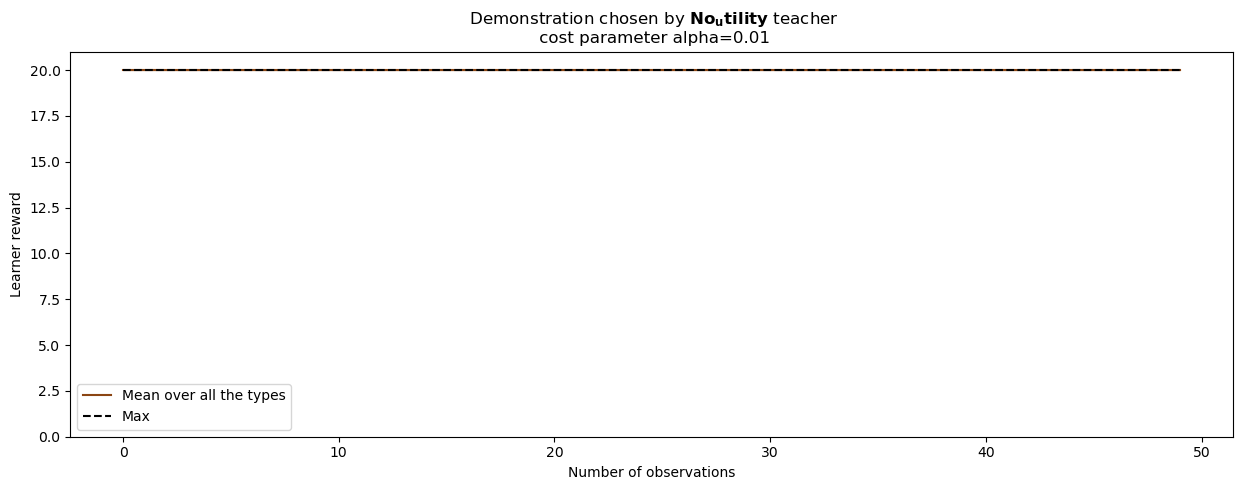

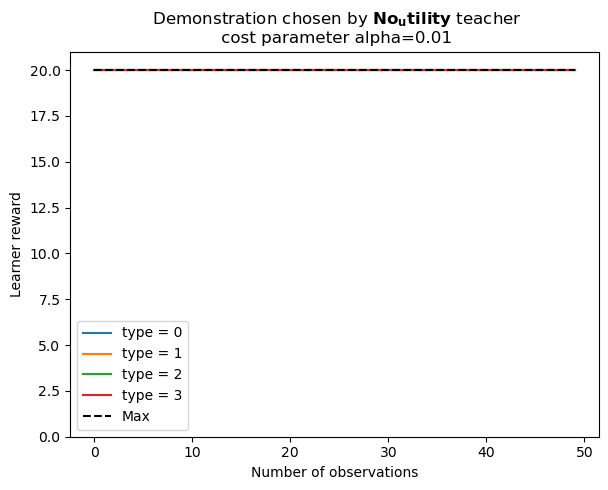

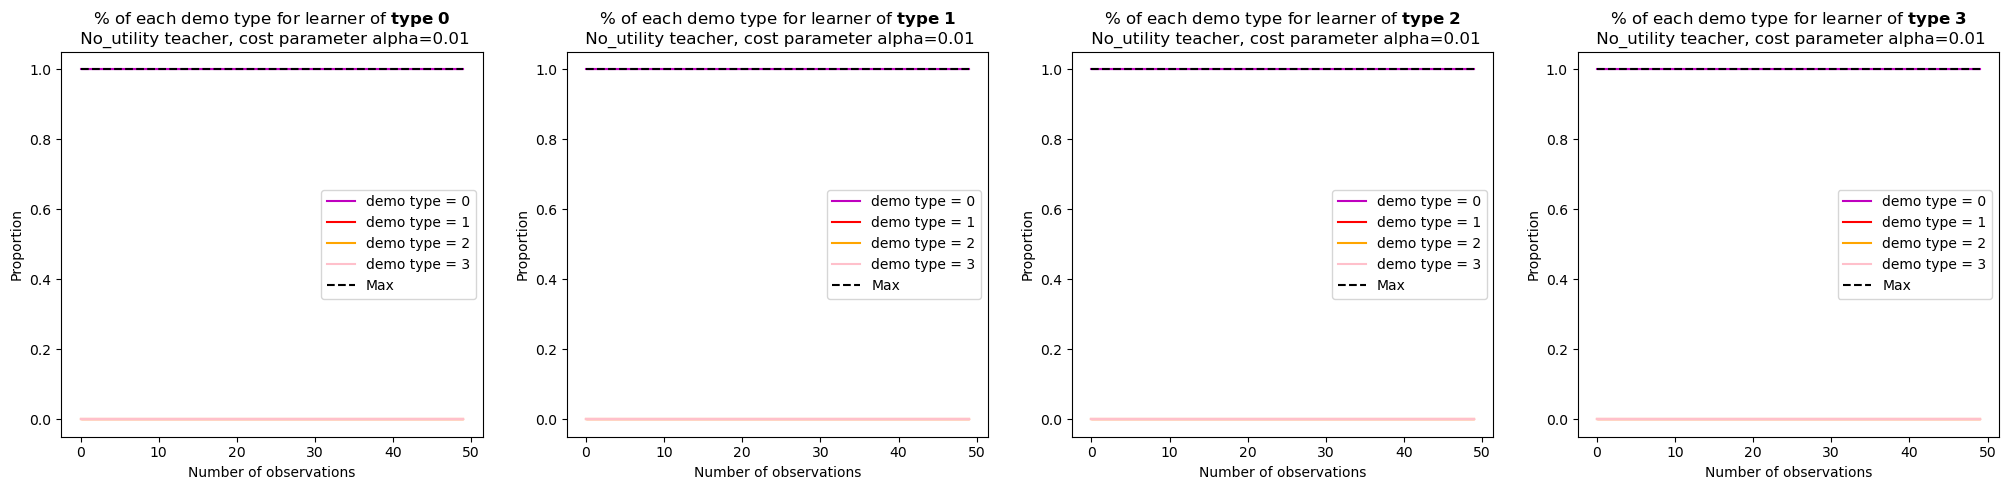

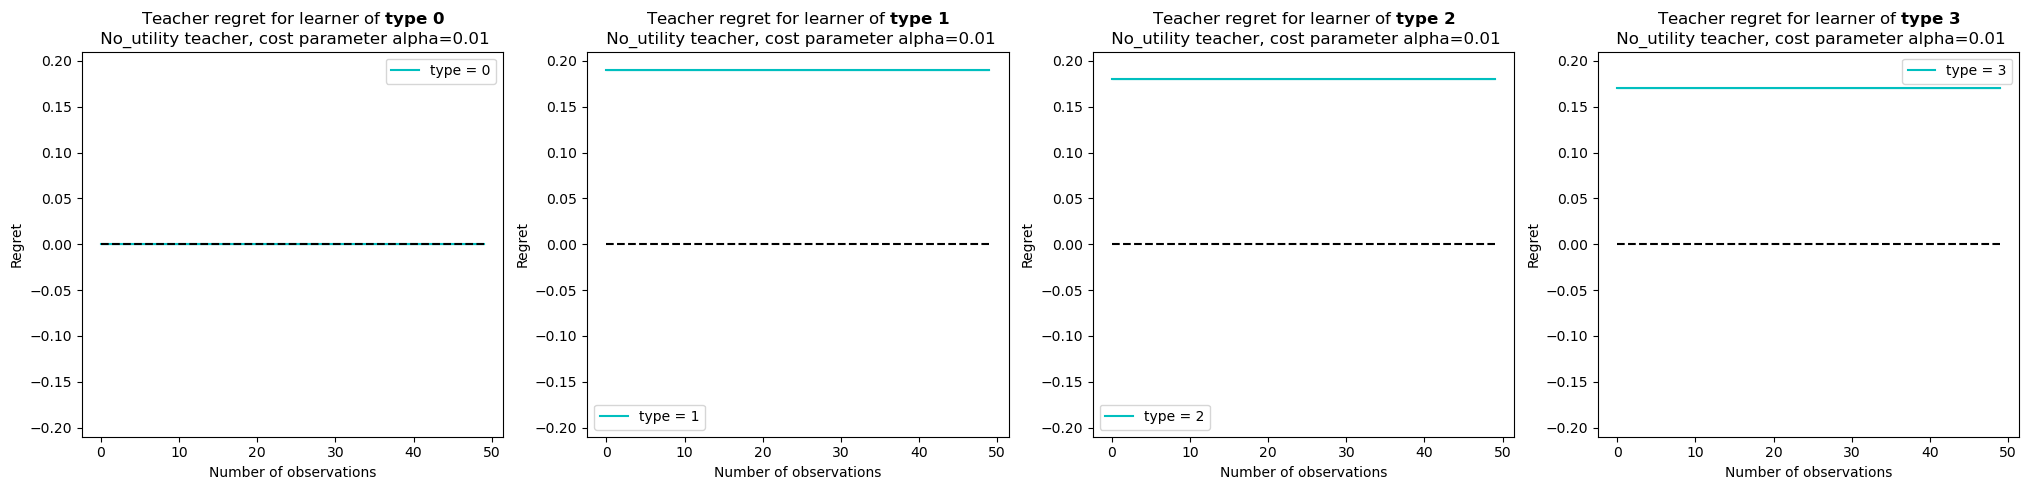

In [78]:
method, alpha = 'No_utility', 0.01
display_evaluation(method, alpha)

#### Saving

In [25]:
save_data(DICT, '/home/chetouani/Documents/STAGE_Clemence/ISIR_internship_ToM/experimental_setup_meta/outputs/bayesian_ToM', 'teacher_eval')

### Tracking changeable learner

In [146]:
# Global evaluation parameters
#DICT_tracking = {}
DICT_tracking = load_data('/home/chetouani/Documents/STAGE_Clemence/ISIR_internship_ToM/experimental_setup_meta/outputs/bayesian_ToM/teacher_eval_change_tracking.json')
LOADED = True

N = 100
N_envs = 3
num_obs = 60

n_eval = 20

#### Experiments and display

In [147]:
def evaluate_tracking(changing_step: int, method: str, init_type: int, final_type: int, alpha: float=0.01, save: bool=True) -> None:
    if method not in DICT_tracking.keys():
        DICT_tracking[method] = {}
    DICT_tracking[method][changing_step] = {}
    DICT_tracking[method][changing_step]['rewards'] = []
    DICT_tracking[method][changing_step]['demo'] = []
    DICT_tracking[method][changing_step]['uncertainty'] = []
    for _ in range(N_envs):
        # Init envs
        observation_env = ButtonsToy(n_buttons, n_music)
        demonstration_env = ButtonsToy(n_buttons, n_music)
        for _ in range(N):
            cum_rewards = []
            all_demo = []
            uncertainties = []
            for n in range(num_obs):
                # Init teacher
                if method == 'MAP' or method == 'Bayesian':
                    teacher = BaysesianTeacher(env=observation_env,
                                                num_types=num_types)
                elif method == 'Uniform' or method == 'No_utility':
                    teacher = NaiveTeacher(env=observation_env,
                                                num_types=num_types)
                # Init learner
                learner = Learner(init_type)
                learner.init_env(observation_env)
                if method == 'MAP' or method == 'Bayesian':
                    # Observe the learner
                    traj = learner.act(size = min(changing_step, n))
                    teacher.observe(traj)
                    if n > changing_step:
                        # Change learner type
                        learner.type = final_type
                        traj = learner.act(size = n - changing_step)
                        teacher.observe(traj)
                    # Teacher uncertainty
                    uncertainties.append(Shannon_entropy(teacher.beliefs))
                # Chose demonstration
                teacher.init_env(demonstration_env)
                demo = teacher.demonstrate(method=method, alpha=alpha)
                # Show the demonstration
                learner.init_env(demonstration_env)
                learner.observe(demo)
                # Evaluate hwo helpful has been the demonstration
                _, rewards = learner.act(size=n_eval)
                # Append 
                cum_rewards.append(np.sum(rewards))
                all_demo.append(len(demo[0]))
            DICT_tracking[method][changing_step]['rewards'].append(cum_rewards)
            DICT_tracking[method][changing_step]['demo'].append(all_demo)
            DICT_tracking[method][changing_step]['uncertainty'].append(uncertainties)

In [150]:
def display_tracking(method: str, init_type: int, final_type: int, save: bool=True) -> None:
    colors = ['indigo','orchid', 'hotpink', 'coral', 'red', 'brown']
    step_colors = ['indigo', 'purple', 'deeppink', 'orangered', 'darkred', 'saddlebrown']

    if method == 'MAP' or method == 'Bayesian':
        fig0, axes = plt.subplots(2, 1, figsize=(15,10))
    else:
        fig0, axes = plt.subplots(1, 1, figsize=(15,5))
        
    for ii, changing_step in enumerate(DICT_tracking[method].keys()):        
        if method == 'MAP' or method == 'Bayesian':
            ax = axes[0]
        else:
            ax = axes

        # Learner reward
        all_evals = DICT_tracking[method][changing_step]['rewards']
        mean = np.mean(all_evals, axis=0)
        std = np.std(all_evals)

        ax.plot(mean, label=f'changing step = {changing_step}', color=colors[ii])
        ax.set_ylim(0,21)
        ax.fill_between(np.arange(num_obs), mean + 1.96 * std / np.sqrt(N * N_envs), mean - 1.96 * std/np.sqrt(N * N_envs), alpha=0.2, color=colors[ii])
        ax.plot([int(changing_step)] * num_obs, np.linspace(0, 20, num_obs), ls='--', color=step_colors[ii])

        # Teacher uncertainty
        if method == 'MAP' or method == 'Bayesian':
            ax = axes[1]
            all_evals = DICT_tracking[method][changing_step]['uncertainty']
            mean = np.mean(all_evals, axis=0)
            std = np.std(all_evals)

            ax.plot(mean, label=f'changing step = {changing_step}', color=colors[ii])
            ax.set_ylim(- 0.5, Shannon_entropy(np.ones(num_types) / num_types) + 0.5)
            ax.fill_between(np.arange(num_obs), mean + 1.96 * std / np.sqrt(N * N_envs), mean - 1.96 * std/np.sqrt(N * N_envs), alpha=0.2, color=colors[ii])
            ax.plot([int(changing_step)] * num_obs, np.linspace(-0.5, 10, num_obs), ls='--', color=step_colors[ii])

    if method == 'MAP' or method == 'Bayesian':
        ax = axes[0]
    else:
        ax = axes
    # Learner total reward on trajectory of size 20 (after seen the teacher demonstration)
    ax.plot(np.arange(num_obs), [20] * num_obs, c='k', label="Max", ls='--')
    ax.set_xlabel('Number of observations')
    ax.set_ylabel('Learner reward')
    ax.legend()

    if method == 'MAP' or method == 'Bayesian':
        # Teacher uncertainty (Shannon entropy)
        axes[1].plot(np.arange(num_obs), [0] * num_obs, c='k', label="Min", ls='--')
        axes[1].set_xlabel('Number of observations')
        axes[1].set_ylabel('Teacher uncertainty')
        axes[1].legend()
    # Suptitle
    fig0.suptitle(fr' Demonstration chosen by $\mathbf{{{method}}}$ teacher ' + '\n' + \
        fr' Learner changing from type $\mathbf{{{init_type}}}$ to type $\mathbf{{{final_type}}}$')
    

    # Repartition btw type of demonstrations shown
    demo_colors = ['m', 'red', 'orange', 'pink']
    dict_length = len(DICT_tracking[method].keys())
    num_col = 3
    fig1, axes = plt.subplots(dict_length // num_col + 1 * (dict_length % num_col > 0), num_col, figsize=(20, 10))
    for ii, changing_step in enumerate(DICT_tracking[method].keys()):
        if dict_length > 1:
            ax = axes[ii // num_col, ii % num_col]
        else:
            ax = axes
        for demo_type in range(num_demo_types):
            demo_rep = np.array(DICT_tracking[method][changing_step]['demo'])
            if demo_type == 0:
                prop_demo = np.array(demo_rep == n_buttons)
            else:
                prop_demo = np.array(demo_rep == demo_type)
            mean = np.mean(prop_demo, axis=0)
            std = np.std(prop_demo)

            ax.plot(mean, label=f'demo type = {demo_type}', color=demo_colors[demo_type])
            ax.fill_between(np.arange(num_obs), mean + 1.96 * std / np.sqrt(N + N_envs), mean - 1.96 * std/np.sqrt(N + N_envs), alpha=0.2, color=demo_colors[demo_type])
            ax.plot([int(changing_step)] * num_obs, np.linspace(0, 1, num_obs), ls='--', color=step_colors[ii])
        ax.plot(np.arange(num_obs), [1] * num_obs, c='k', label="Max", ls='--')

        ax.set_title(f'Learner changing from type {init_type} to type {final_type} ' + \
                      fr'at $\mathbf{{step}}$ $\mathbf{{{changing_step}}}$')

        ax.set_xlabel('Number of observations')
        ax.set_ylabel('Proportion')
        ax.legend()

    # Super figure
    figs = [fig0, fig1]
    saving_names = ['per_step','chosen_demo']
    if save:
        for ii, fig in enumerate(figs):
            fig.savefig(f'/home/chetouani/Documents/STAGE_Clemence/ISIR_internship_ToM/experimental_setup_meta/figures/bayesian_ToM/{method}/eval_with_changing_learner_from_{init_type}_to_{final_type}_{saving_names[ii]}_{method}_{alpha}.png')
    


#### MAP teacher

In [29]:
changing_step_values = [0, 10, 20, 30, 40, 50]
for changin_step in changing_step_values:
    evaluate_tracking(changin_step, 'MAP', init_type=2, final_type=3)

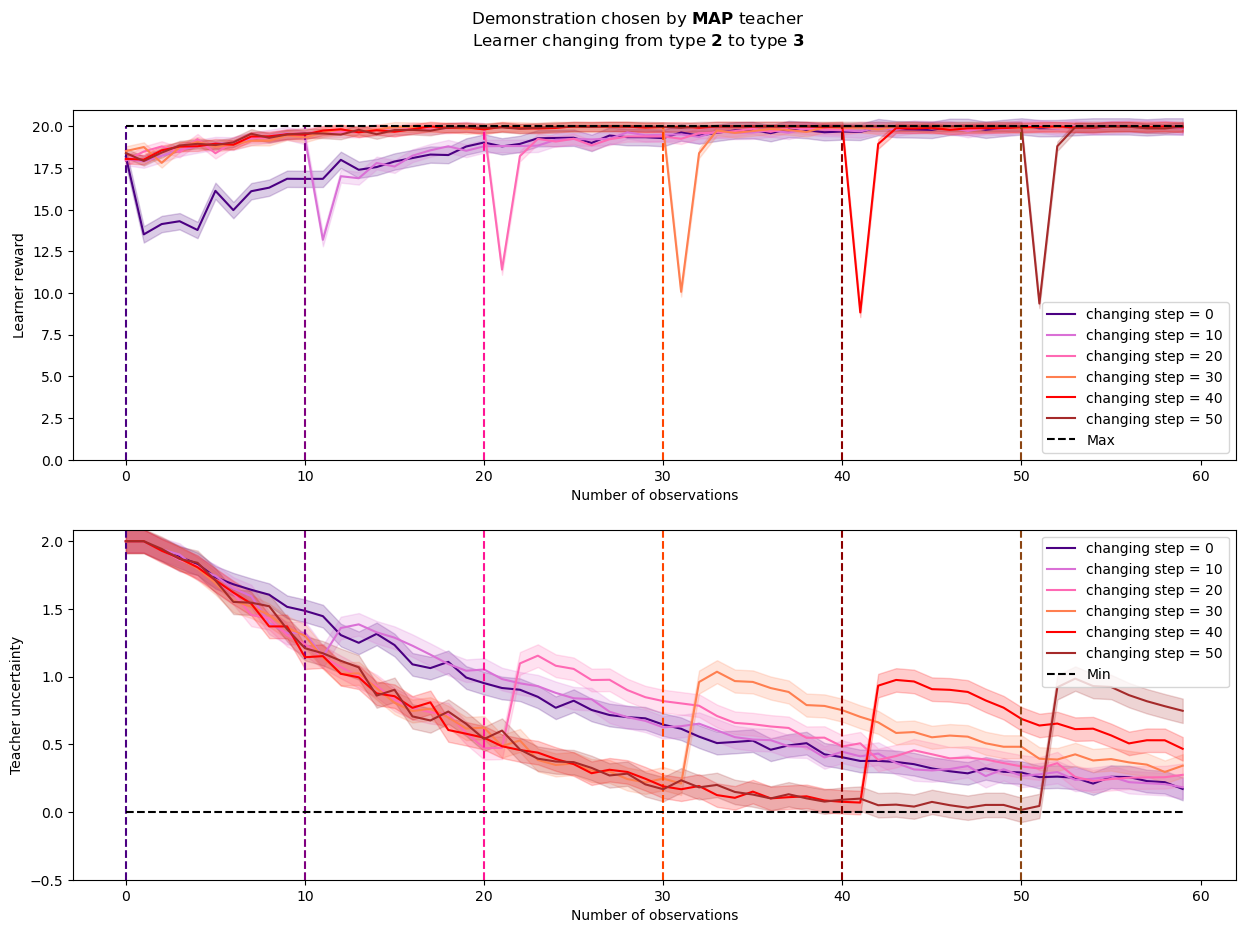

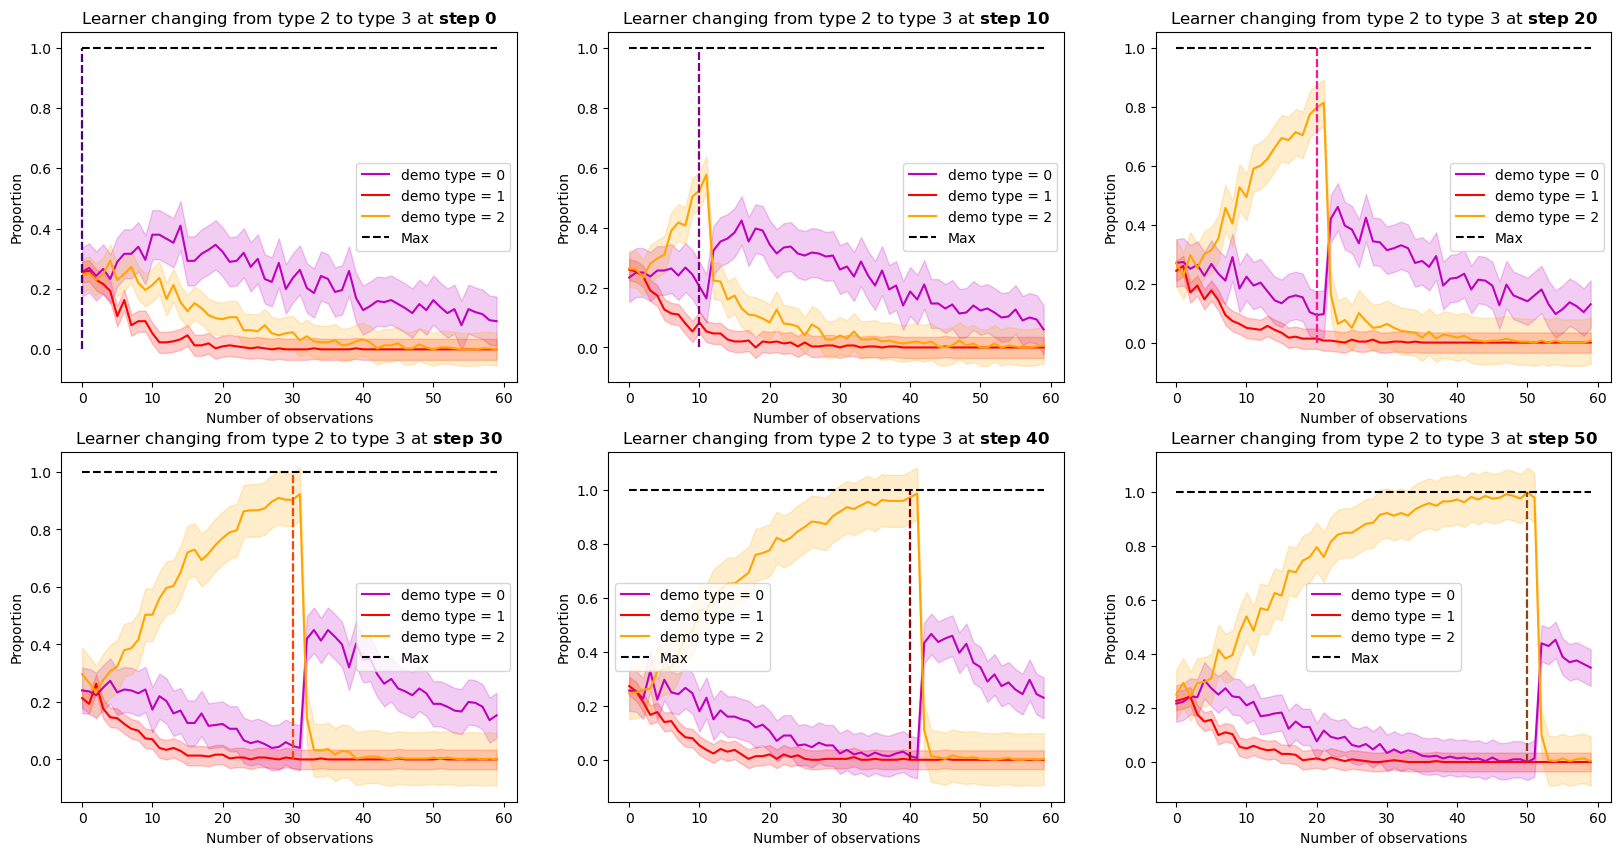

In [151]:
display_tracking('MAP', init_type=2, final_type=3)

#### Bayesian Teacher

In [31]:
changing_step_values = [0, 10, 20, 30, 40, 50]
for changin_step in changing_step_values:
    evaluate_tracking(changin_step, 'Bayesian', init_type=2, final_type=3)

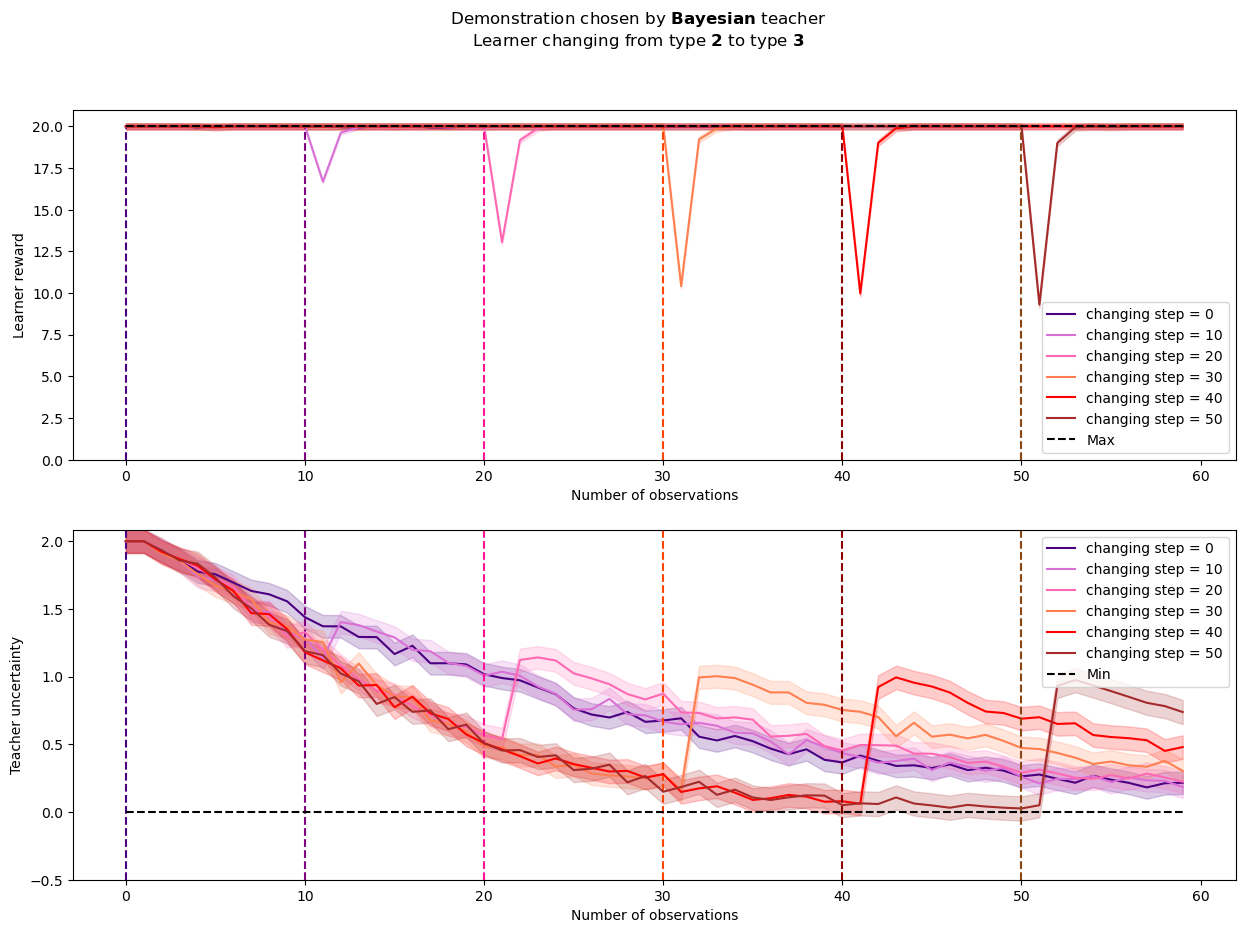

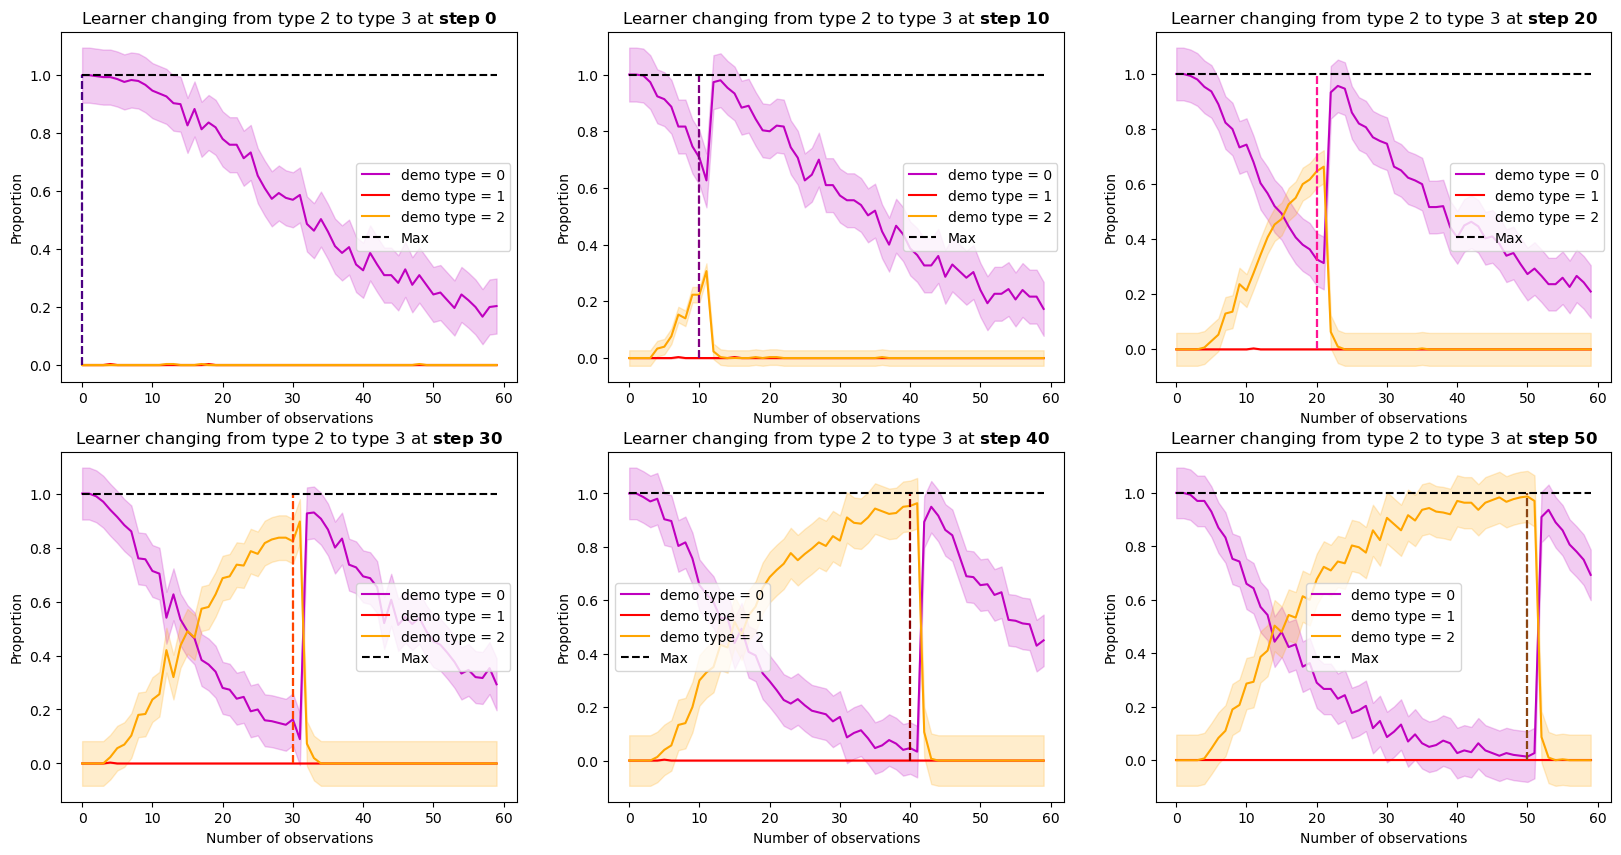

In [154]:
display_tracking('Bayesian', init_type=2, final_type=3)

#### Uniform teacher

In [33]:
changing_step_values = [0, 10, 20, 30, 40, 50]
for changin_step in changing_step_values:
    evaluate_tracking(changin_step, 'Uniform', init_type=2, final_type=3)

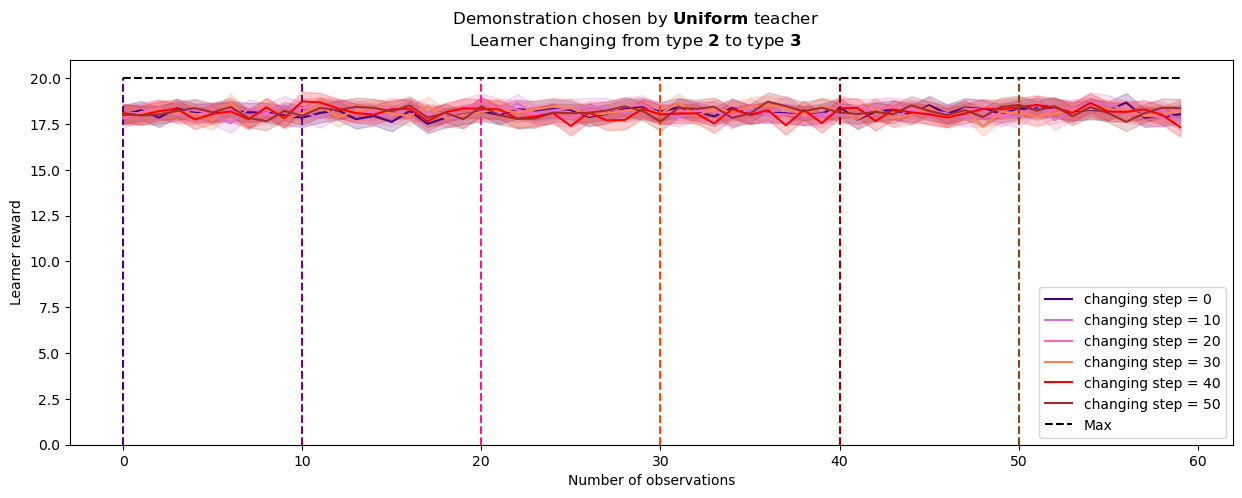

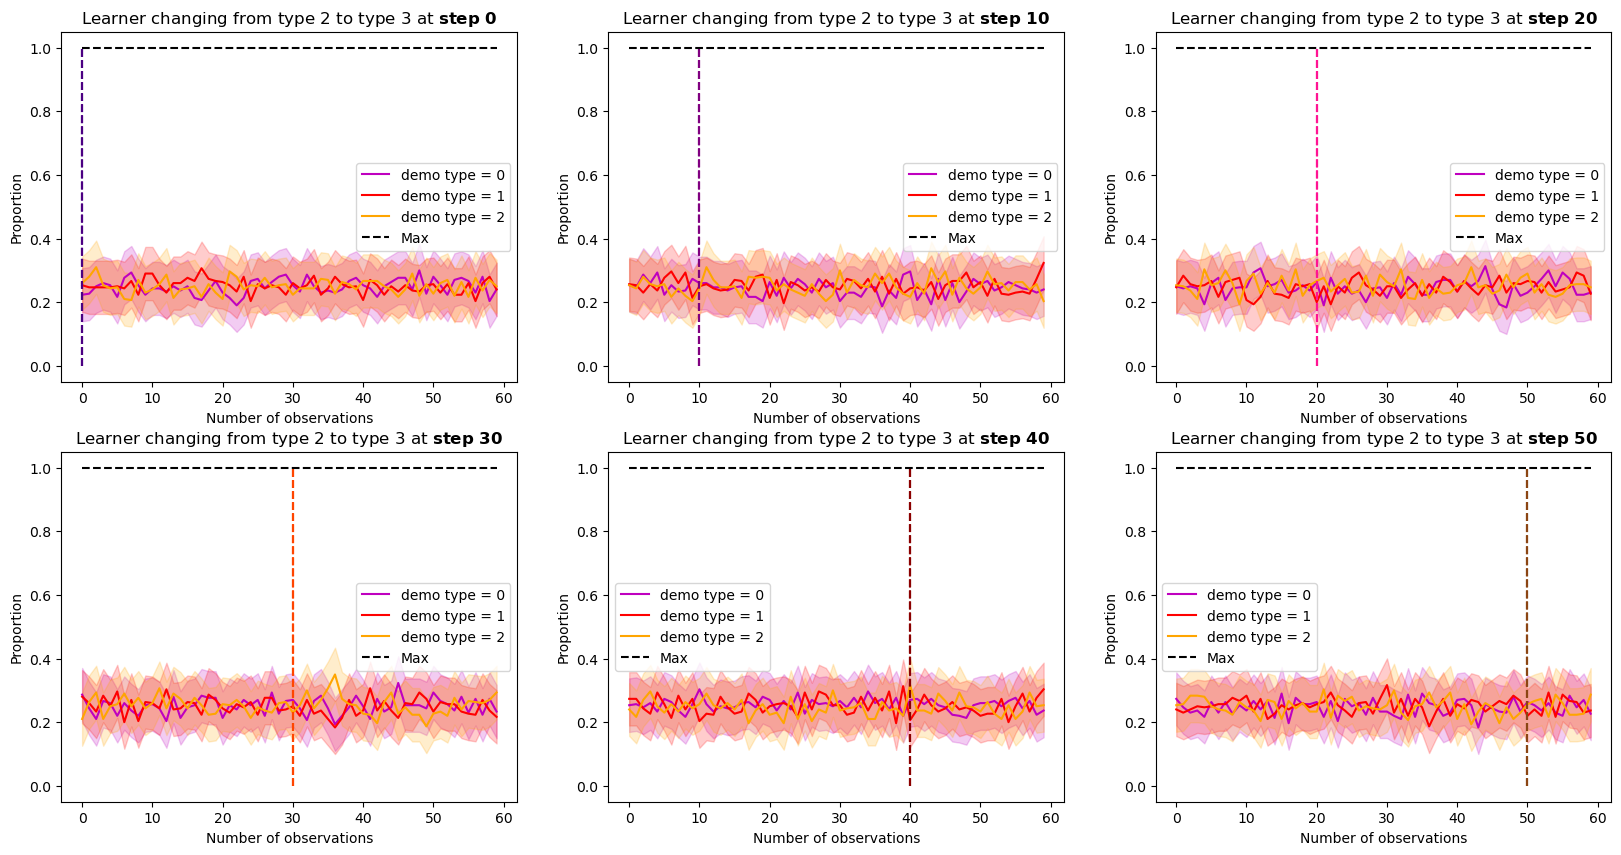

In [152]:
display_tracking('Uniform', init_type=2, final_type=3)

#### No_utility teacher

In [35]:
changing_step_values = [0, 10, 20, 30, 40, 50]
for changin_step in changing_step_values:
    evaluate_tracking(changin_step, 'No_utility', init_type=2, final_type=3)

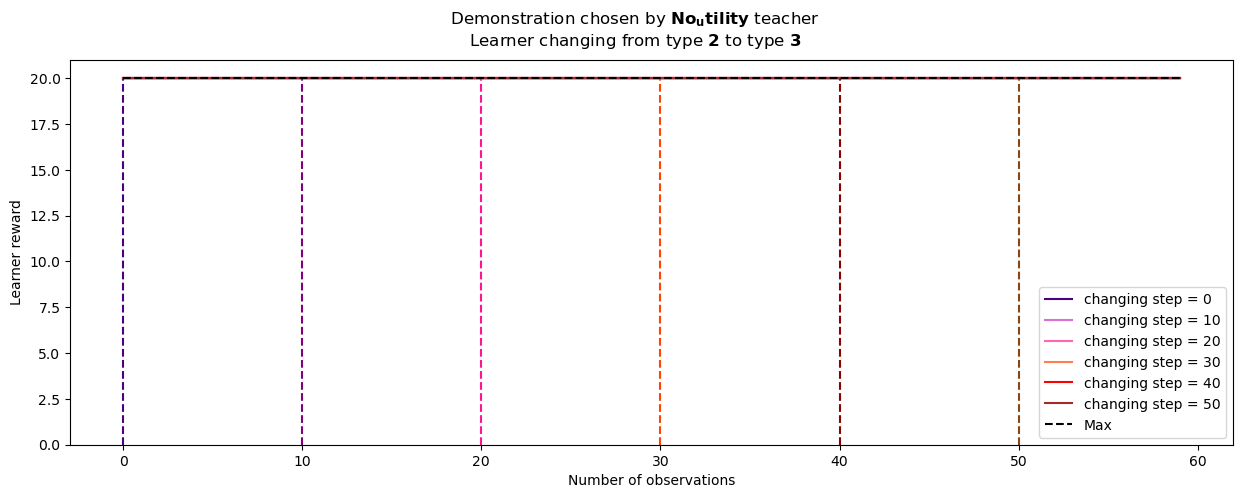

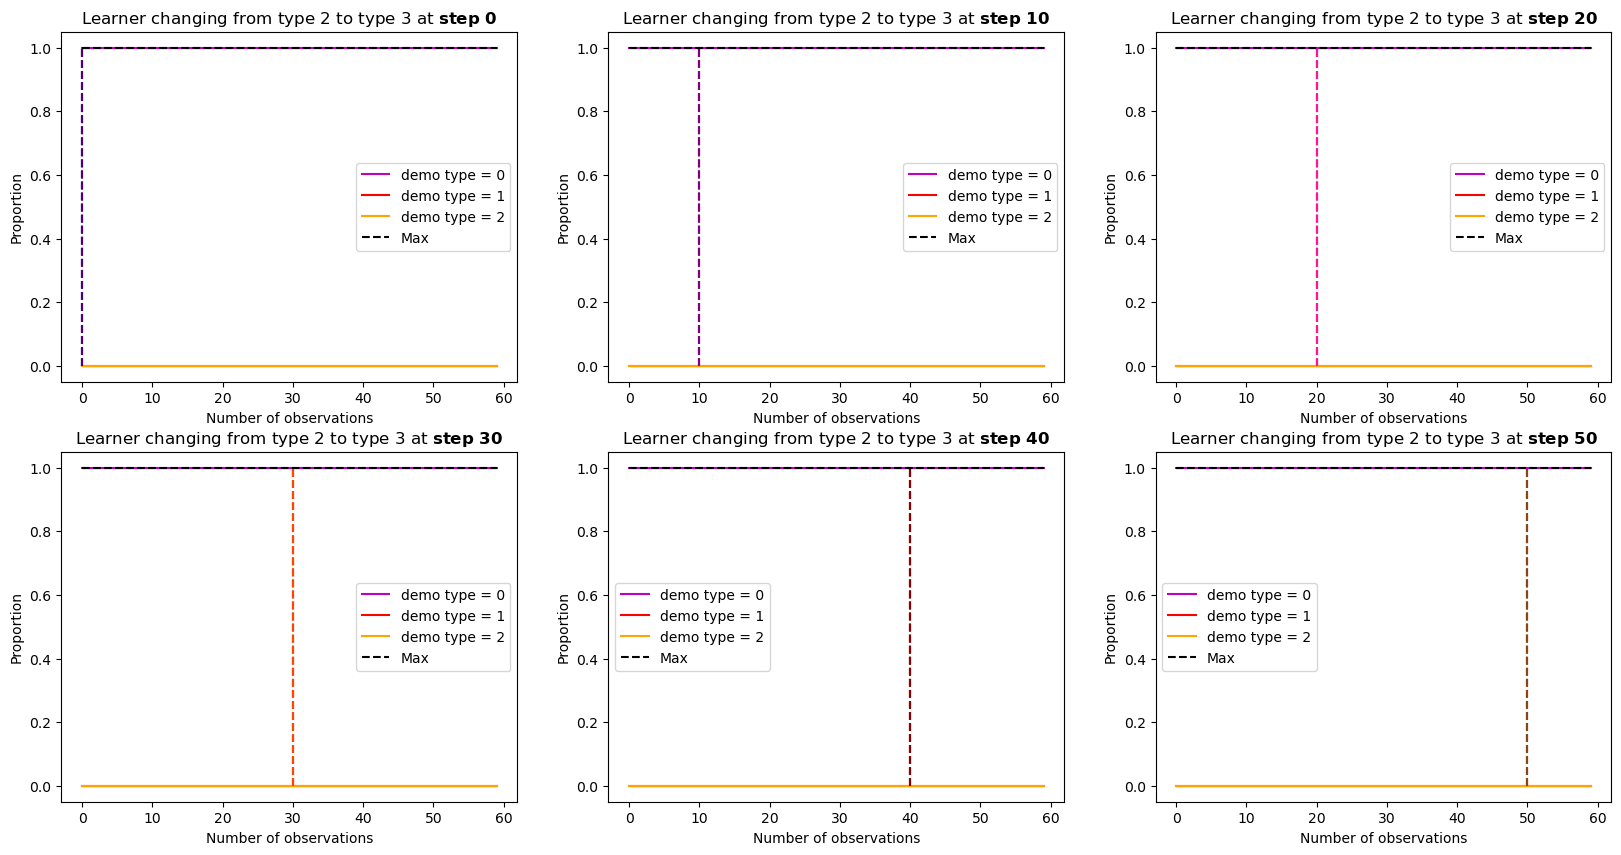

In [153]:
display_tracking('No_utility', init_type=2, final_type=3)

#### Saving

In [37]:
save_data(DICT_tracking, '/home/chetouani/Documents/STAGE_Clemence/ISIR_internship_ToM/experimental_setup_meta/outputs/bayesian_ToM', 'teacher_eval_change_tracking')

### Unknown learner type

Observation environment


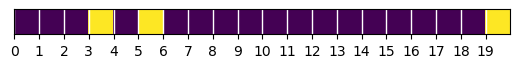

Demonstration environment


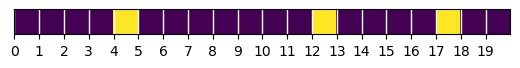

In [121]:
observation_env = ButtonsToy(n_buttons, n_music)
print('Observation environment')
observation_env.render()
plt.show()

demonstration_env = ButtonsToy(n_buttons, n_music)
print('Demonstration environment')
demonstration_env.render()
plt.show()

num_types = 3 # Remove learner of type 3 (and associated demo) from the support of the teacher beliefs
num_demo_types = num_types
unknown_type = 3

In [134]:
# Global evaluation parameters
DICT_unknown = {}

N = 100
N_envs = 3
num_obs = 100

n_eval = 20

#### Experiments and display

In [135]:
def evaluate_unknown(method: str, alpha: float) -> None:
    if method not in DICT_unknown.keys():
        DICT_unknown[method] = {}
    DICT_unknown[method][alpha] = {}
    DICT_unknown[method][alpha][unknown_type] = {}
    DICT_unknown[method][alpha][unknown_type]['rewards'] = []
    DICT_unknown[method][alpha][unknown_type]['demo'] = []
    DICT_unknown[method][alpha][unknown_type]['uncertainty'] = []
    DICT_unknown[method][alpha][unknown_type]['teacher_regret'] = []
    for _ in range(N_envs):
        # Init envs
        observation_env = ButtonsToy(n_buttons, n_music)
        demonstration_env = ButtonsToy(n_buttons, n_music)
        for _ in range(N):
            cum_rewards = []
            all_demo = []
            uncertainties = []
            for n in range(num_obs):
                # Init teacher
                if method == 'MAP' or method == 'Bayesian':
                    teacher = BaysesianTeacher(env=observation_env,
                                                num_types=num_types)
                elif method == 'Uniform' or method == 'No_utility':
                    teacher = NaiveTeacher(env=observation_env,
                                                num_types=num_types)
                # Init learner
                learner = Learner(unknown_type) # unknown type for the teacher
                learner.init_env(observation_env)
                if method == 'MAP' or method == 'Bayesian':
                    # Observe the learner
                    traj = learner.act(size=n)
                    teacher.observe(traj)
                    # Teacher uncertainty
                    uncertainties.append(Shannon_entropy(teacher.beliefs))
                # Chose demonstration
                teacher.init_env(demonstration_env)
                demo = teacher.demonstrate(method=method, alpha=alpha)
                # Show the demonstration
                learner.init_env(demonstration_env)
                learner.observe(demo)
                # Evaluate hwo helpful has been the demonstration
                _, rewards = learner.act(size=n_eval)
                # Append
                cum_rewards.append(np.sum(rewards))
                all_demo.append(len(demo[0]))
            DICT_unknown[method][alpha][unknown_type]['rewards'].append(cum_rewards)
            DICT_unknown[method][alpha][unknown_type]['demo'].append(all_demo)
            DICT_unknown[method][alpha][unknown_type]['uncertainty'].append(uncertainties)

In [136]:
def display_evaluation_unknwon(method: str, alpha: float, save: bool=True):
    demo_colors = ['m', 'red', 'orange', 'pink']

    suptitle = f'Evaluation of the {method} teacher on unknwon learner type {unknown_type} (with cost parameter alpha={alpha})'
    centered_suptitle = suptitle.center(150)
    print(f"\033[1m" + centered_suptitle + f"\033[0m ")

    fig0 = plt.figure(figsize=(15,5))
    # Learner total reward on trajectory of size 20 (after seen the demo chosen by the teacher (unknown learner type)
    all_evals = np.array(DICT_unknown[method][alpha][unknown_type]['rewards'])
    mean = np.mean(all_evals, axis=0)
    std = np.std(all_evals)

    plt.plot(mean, label=f'mean')
    plt.ylim(0, 21)
    plt.fill_between(np.arange(num_obs), mean + 1.96 * std / np.sqrt(N * N_envs), mean - 1.96 * std / np.sqrt(N * N_envs), alpha=0.2)
    plt.plot(np.arange(num_obs), [20] * num_obs, c='k', label="Max", ls='--')
    plt.title(fr' Demonstration chosen by $\mathbf{{{method}}}$ teacher for $\mathbf{{unknwon learner of type {unknown_type}}}$' + f'\n cost parameter alpha={alpha} (95% c.i)')

    plt.xlabel('Number of observations')
    plt.ylabel('Learner reward')
    plt.legend()

    fig1 = plt.figure(figsize=(15,5))

    # Teacher uncertainty
    fig1.add_subplot(1,2,1)
    if method == 'MAP' or method == 'Bayesian':
        all_evals = np.array(DICT_unknown[method][alpha][unknown_type]['uncertainty'])
        mean = np.mean(all_evals, axis=0)
        std = np.std(all_evals)

        plt.plot(mean, label=f'type = {unknown_type}')
        plt.ylim(- 0.5 , Shannon_entropy(np.ones(num_types) / num_types) + 0.5)
        plt.fill_between(np.arange(num_obs), mean + 1.96 * std / np.sqrt(N * N_envs), mean - 1.96 * std/np.sqrt(N * N_envs), alpha=0.2)
        plt.plot(np.arange(num_obs), [0] * num_obs, c='k', label="Min", ls='--')
        plt.title(fr'$\mathbf{{{method}}}$ teacher (95% c.i)')

        plt.xlabel('Number of observations')
        plt.ylabel('Teacher uncertainty (Shannon entropy)')
        plt.legend()

    # Repartition btw type of demonstrations shown
    fig1.add_subplot(1,2,2)
    for demo_type in range(num_demo_types):
        demo_rep = np.array(DICT_unknown[method][alpha][unknown_type]['demo'])
        if demo_type == 0:
            prop_demo = np.array(demo_rep == n_buttons)
        else:
            prop_demo = np.array(demo_rep == demo_type)
        mean = np.mean(prop_demo, axis=0)
        std = np.std(prop_demo)

        plt.plot(mean, label=f'demo type = {demo_type}', color=demo_colors[demo_type])
        plt.fill_between(np.arange(num_obs), mean + 1.96 * std / np.sqrt(N + N_envs), mean - 1.96 * std/np.sqrt(N + N_envs), alpha=0.2, color=demo_colors[demo_type])
    plt.plot(np.arange(num_obs), [1] * num_obs, c='k', label="Max", ls='--')

    plt.title(f'% of each demo type for learner of unknown $\mathbf{{type}}$ ' + fr'$\mathbf{{{unknown_type}}}$' +  f'\n {method} teacher, cost parameter alpha={alpha} (95% c.i)')
    plt.xlabel('Number of observations')
    plt.ylabel('Proportion')
    plt.legend()


# Super figure
    figs = [fig0, fig1]
    saving_names = ['reward','chosen_demo']
    if save:
        for ii, fig in enumerate(figs):
            fig.savefig(f'/home/chetouani/Documents/STAGE_Clemence/ISIR_internship_ToM/experimental_setup_meta/figures/bayesian_ToM/{method}/eval_with_unknown_learner_{saving_names[ii]}_{method}_{alpha}.png')

#### MAP teacher

In [137]:
method, alpha = 'MAP', 0.01
evaluate_unknown(method, alpha)

/home/chetouani/Documents/STAGE_Clemence/ISIR_internship_ToM/experimental_setup_meta/learner.py:31: RuntimeWarning: invalid value encountered in divide
  updated_beliefs[a, :] /= updated_beliefs[a, :].sum()
/home/chetouani/Documents/STAGE_Clemence/ISIR_internship_ToM/experimental_setup_meta/utils.py:37: RuntimeWarning: divide by zero encountered in log2
  tab = proba_dist * np.log2(proba_dist)
/home/chetouani/Documents/STAGE_Clemence/ISIR_internship_ToM/experimental_setup_meta/utils.py:37: RuntimeWarning: invalid value encountered in multiply
  tab = proba_dist * np.log2(proba_dist)


                               Evaluation of the MAP teacher on unknwon learner type 3 (with cost parameter alpha=0.01)                                


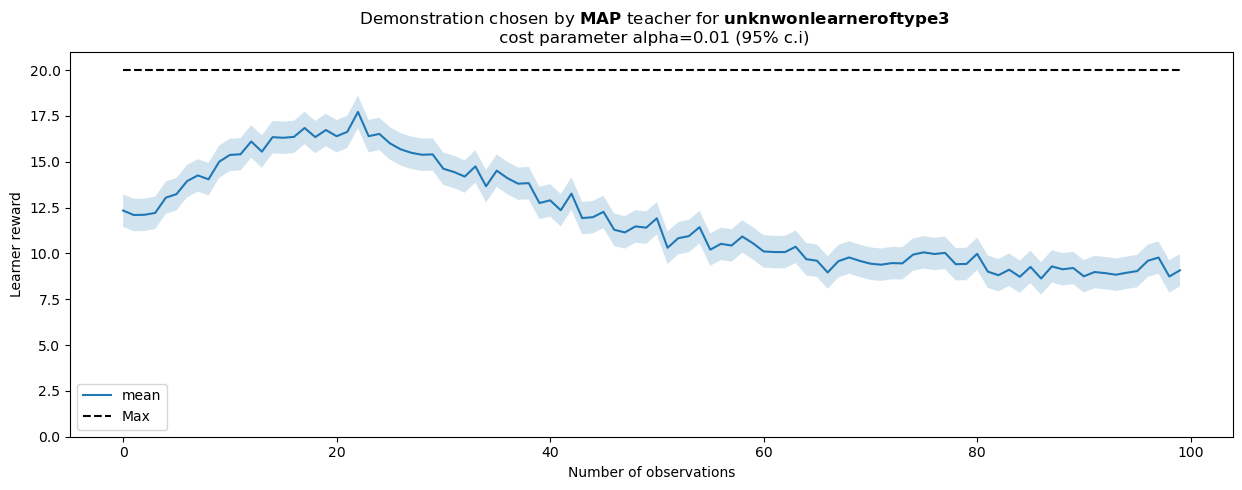

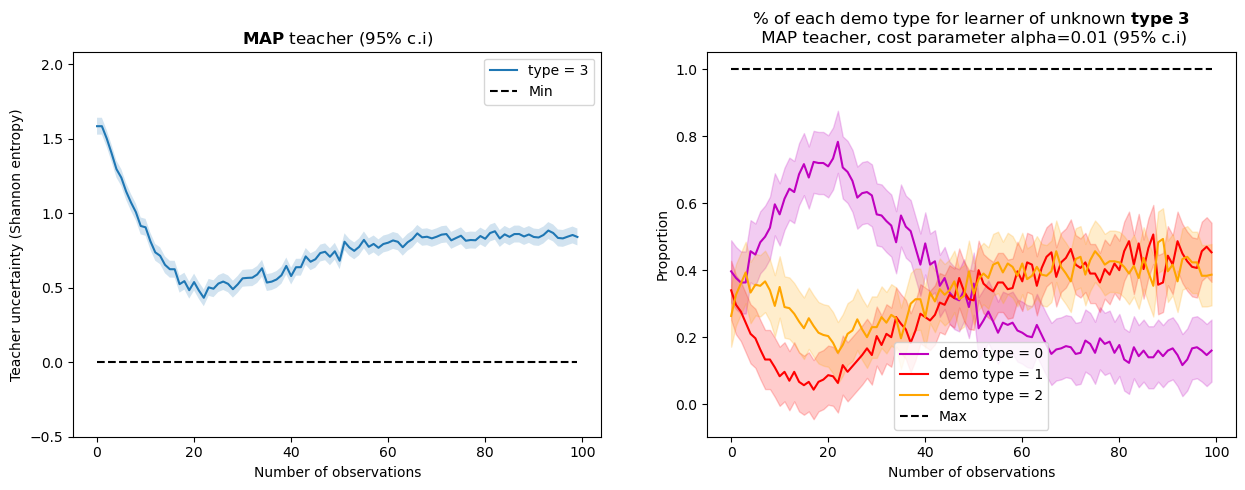

In [138]:
display_evaluation_unknwon('MAP', alpha, save=True)

#### Bayesian teacher

In [139]:
method, alpha = 'Bayesian', 0.01
evaluate_unknown(method, alpha)

                            Evaluation of the Bayesian teacher on unknwon learner type 3 (with cost parameter alpha=0.01)                              


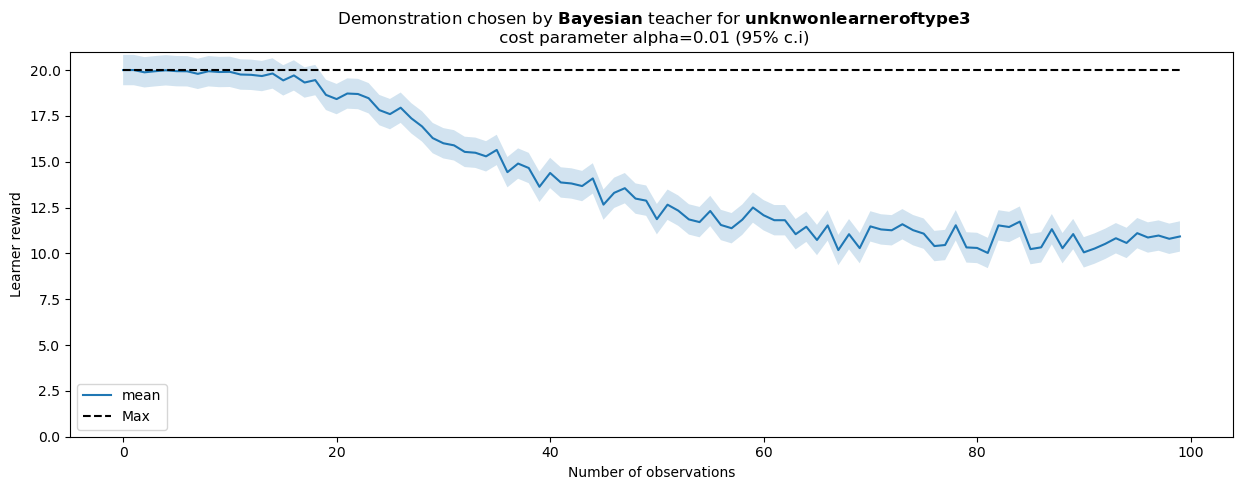

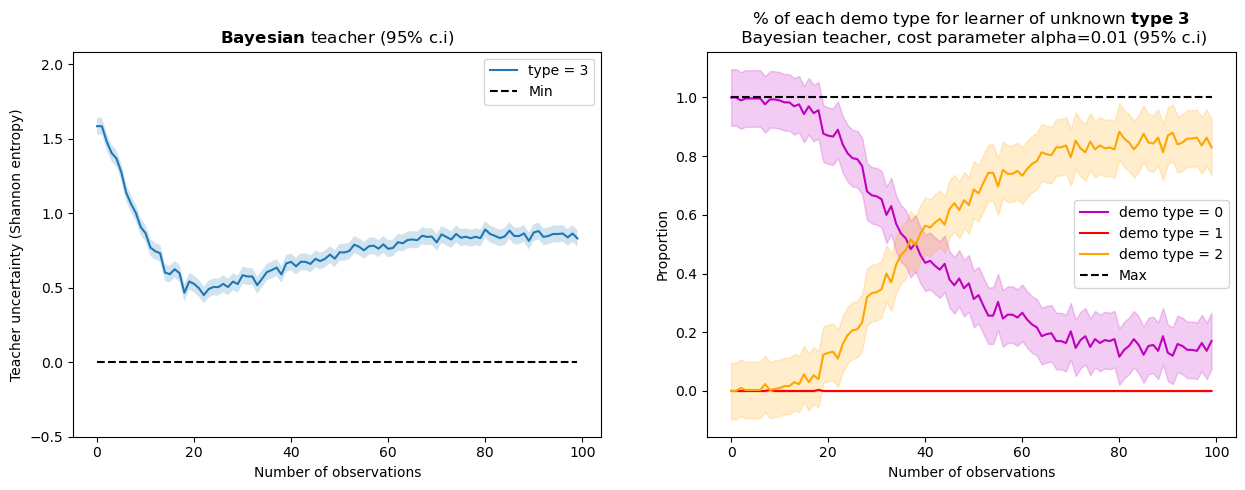

In [140]:
display_evaluation_unknwon('Bayesian', alpha, save=True)

#### Uniform teacher

In [141]:
method, alpha = 'Uniform', 0.01
evaluate_unknown(method, alpha)

                             Evaluation of the Uniform teacher on unknwon learner type 3 (with cost parameter alpha=0.01)                              


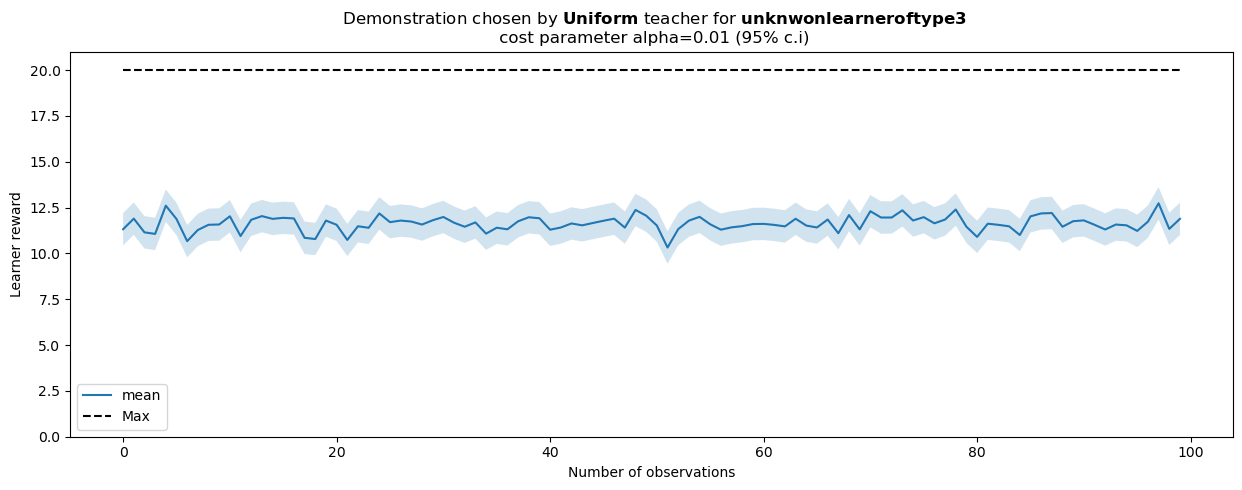

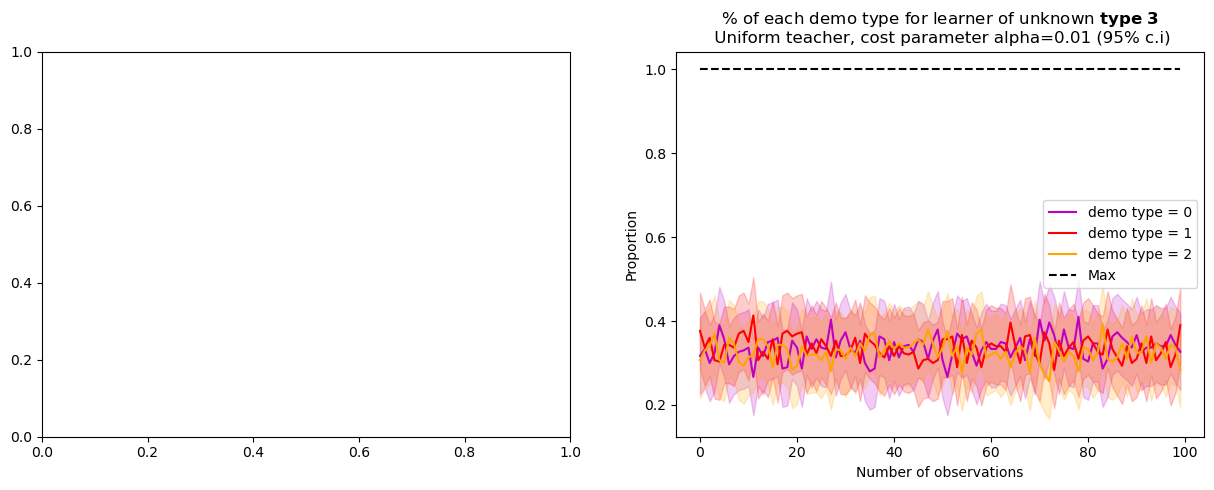

In [142]:
display_evaluation_unknwon('Uniform', alpha, save=True)

#### No_utility teacher

In [143]:
method, alpha = 'No_utility', 0.01
evaluate_unknown(method, alpha)

                           Evaluation of the No_utility teacher on unknwon learner type 3 (with cost parameter alpha=0.01)                             


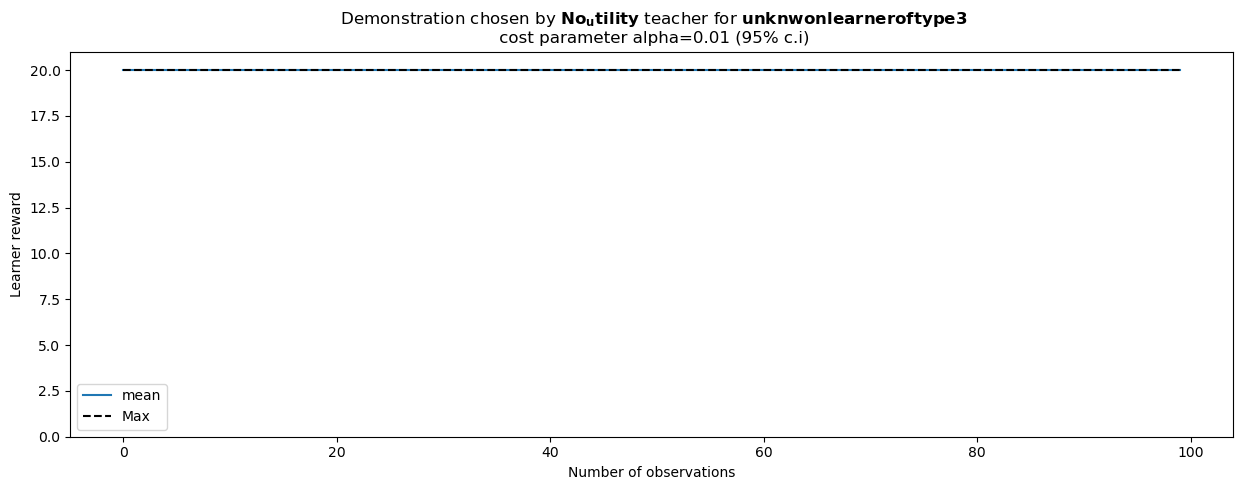

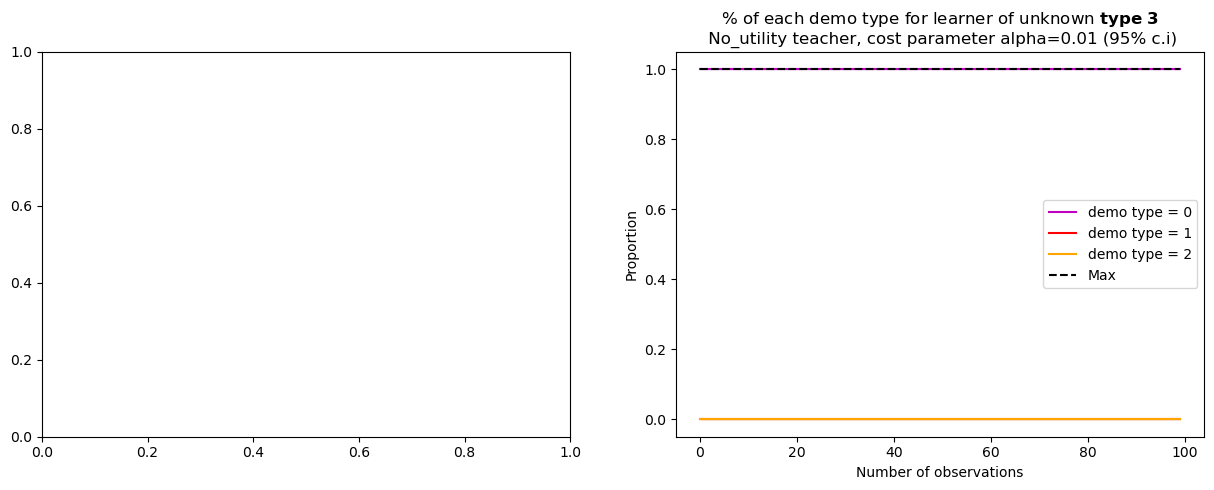

In [144]:
display_evaluation_unknwon('No_utility', alpha, save=True)

## ToMNet Teacher

In [ ]:
from storage import Storage
from dataset import ToMNetDataset, save_data, load_data
from torch.utils.data import DataLoader

In [ ]:
n_buttons = 20
n_music = 3

num_past = 10
max_steps = 30
min_steps = 0

n_agent_train = 10
n_agent_test = 10

batch_size = 10

In [ ]:
train_store = Storage(n_buttons=n_buttons,
        n_music=n_music,
        max_steps=max_steps,
        num_past=num_past,
        num_types=4,
        num_agents=n_agent_train,
        num_demo_types=4,
        min_steps=min_steps
        )

eval_store = Storage(n_buttons=n_buttons,
        n_music=n_music,
        max_steps=max_steps,
        num_past=num_past,
        num_types=4,
        num_agents=n_agent_test,
        num_demo_types=4,
        min_steps=min_steps
        )

train_data = train_store.extract()
eval_data = eval_store.extract()
train_dataset = ToMNetDataset(**train_data)
eval_dataset = ToMNetDataset(**eval_data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)